In [ ]:
# data processing to arrow (unused)
import string
import re
import numpy as np
from collections import Counter, defaultdict
import textstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import json # No longer needed for saving the main data if using HF Datasets
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from transformers import BertTokenizerFast, pipeline, BatchEncoding
import torch
import accelerate
from typing import List, Dict, Union
from sklearn.preprocessing import MinMaxScaler
import pickle

# NEW: Import Hugging Face Datasets
from datasets import Dataset #, Features, Value, Sequence # Optional for explicit schema

# --- [Your TextFeatureExtractor, show_corr, clean_train, get_q_score, append_q_score_train, to_input, pretokenize classes/functions remain largely the same] ---
# Make sure they are defined before df_preprocess or imported.
# I'll assume they are present as in your original code.

traits = ['Openness','Conscientiousness','Extraversion','Agreeableness','Emotional stability','Humility']

class TextFeatureExtractor:
    """
    A class to extract various linguistic and sentiment features from text data,
    designed to work with a Pandas DataFrame where each row contains a list of
    comment strings for a user/entry.
    """

    def __init__(self,
                 specific_punctuation_to_track: list = None,
                 readability_agg_method: str = "concat",
                 ttr_agg_method: str = "concat"):
        """
        Initializes the TextFeatureExtractor.

        Args:
            specific_punctuation_to_track (list, optional):
                A list of specific punctuation marks to count.
                Defaults to ['!', '?', '.', ','].
            readability_agg_method (str, optional):
                Method to aggregate readability scores ("concat" or "mean").
                Defaults to "concat".
            ttr_agg_method (str, optional):
                Method to aggregate Type-Token Ratio ("concat" or "mean").
                Defaults to "concat".
        """
        self.vader_analyzer = SentimentIntensityAnalyzer()

        if specific_punctuation_to_track is None:
            self.specific_punctuation_to_track = ['!', '?', '.', ',',':',';']
        else:
            self.specific_punctuation_to_track = specific_punctuation_to_track

        self.readability_agg_method = readability_agg_method
        self.ttr_agg_method = ttr_agg_method

        try:
            nltk.data.find('tokenizers/punkt')
        except nltk.downloader.DownloadError:
            print("NLTK 'punkt' tokenizer not found. Downloading...", flush=True)
            nltk.download('punkt', quiet=True)
        except LookupError: # Sometimes it's a LookupError if path is configured but resource missing
             print("NLTK 'punkt' tokenizer not found (LookupError). Downloading...", flush=True)
             nltk.download('punkt', quiet=True)


    # --- I. Basic structural feature helpers (operating on lists from a single DataFrame row) ---

    def _sentence_split(self, comment_list: list) -> list:
        """Splits each comment in a list of comments into sentences."""
        all_sentences_for_user = []
        if not isinstance(comment_list, list): return []
        for comment_text in comment_list:
            if isinstance(comment_text, str) and comment_text.strip():
                sentences = nltk.sent_tokenize(comment_text)
                all_sentences_for_user.append(sentences)
            else:
                all_sentences_for_user.append([]) # Handle empty or non-string comments
        return all_sentences_for_user # Returns list of lists of sentences e.g. [[s1,s2],[s3,s4,s5]]

    def _get_word_counts_per_comment(self, comment_list: list) -> list:
        """Calculates word count for each comment string in a list."""
        if not isinstance(comment_list, list): return []
        return [len(str(comment).split()) if isinstance(comment, str) else 0 for comment in comment_list]

    def _get_sentence_counts_per_comment(self, list_of_sentence_lists: list) -> list:
        """Counts sentences in each original comment (given pre-split sentences)."""
        if not isinstance(list_of_sentence_lists, list): return []
        return [len(sentences_in_one_comment) if isinstance(sentences_in_one_comment, list) else 0 for sentences_in_one_comment in list_of_sentence_lists]

    def _get_sentence_word_counts_per_comment(self, list_of_sentence_lists: list) -> list:
        """Calculates word counts for each sentence within each original comment."""
        result_for_user = []
        if not isinstance(list_of_sentence_lists, list): return []
        for sentences_in_one_comment in list_of_sentence_lists:
            if isinstance(sentences_in_one_comment, list):
                sent_lens = [len(str(sent).split()) if isinstance(sent, str) else 0 for sent in sentences_in_one_comment]
                result_for_user.append(sent_lens)
            else:
                result_for_user.append([])
        return result_for_user

    def _aggregate_numeric_list_of_lists(self, list_of_lists_of_numbers: list, agg_func) -> float:
        """Flattens a list of lists of numbers and applies an aggregation function."""
        if not isinstance(list_of_lists_of_numbers, list): return np.nan
        flat_list = []
        for sublist in list_of_lists_of_numbers:
            if isinstance(sublist, list):
                flat_list.extend(num for num in sublist if isinstance(num, (int, float)) and not np.isnan(num))
        return agg_func(flat_list) if flat_list else np.nan

    def _aggregate_numeric_list(self, list_of_numbers: list, agg_func) -> float:
        """Applies an aggregation function to a list of numbers."""
        if not isinstance(list_of_numbers, list): return np.nan
        valid_numbers = [num for num in list_of_numbers if isinstance(num, (int, float)) and not np.isnan(num)]
        return agg_func(valid_numbers) if valid_numbers else np.nan

    # --- II. Single-text processing helper methods (private) ---

    def _get_punctuation_counts_single(self, text: str) -> dict:
        if not isinstance(text, str): return {}
        counts = Counter(char for char in text if char in self.specific_punctuation_to_track)
        return {punc: counts.get(punc, 0) for punc in self.specific_punctuation_to_track}

    def _get_double_whitespace_count_single(self, text: str) -> int:
        """Counts occurrences of two or more consecutive whitespace characters."""
        if not isinstance(text, str) or not text.strip():
            return 0
        # Find all non-overlapping matches of 2 or more whitespace characters
        matches = re.findall(r"\s{2,}", text)
        return len(matches)

    def _get_readability_scores_single(self, text: str) -> dict:
        if not isinstance(text, str) or not text.strip():
            return {'flesch_reading_ease': np.nan, 'gunning_fog': np.nan}
        try:
            return {
                'flesch_reading_ease': textstat.flesch_reading_ease(text),
                'gunning_fog': textstat.gunning_fog(text)
            }
        except Exception:
            return {'flesch_reading_ease': np.nan, 'gunning_fog': np.nan}

    def _get_mean_word_length_single(self, text: str) -> float:
        if not isinstance(text, str) or not text.strip(): return np.nan
        words = re.findall(r'\b\w+\b', text.lower())
        if not words: return np.nan
        return sum(len(word) for word in words) / len(words)

    def _get_type_token_ratio_single(self, text: str) -> float:
        if not isinstance(text, str) or not text.strip(): return np.nan
        words = re.findall(r'\b\w+\b', text.lower())
        if not words: return np.nan
        return len(set(words)) / len(words) if len(words) > 0 else np.nan

    def _get_vader_sentiment_scores_single(self, text: str) -> dict:
        if not isinstance(text, str):
            return {'sentiment_neg': np.nan, 'sentiment_neu': np.nan,
                    'sentiment_pos': np.nan, 'sentiment_compound': np.nan}
        scores = self.vader_analyzer.polarity_scores(text)
        return {
            'sentiment_neg': scores['neg'], 'sentiment_neu': scores['neu'],
            'sentiment_pos': scores['pos'], 'sentiment_compound': scores['compound']
        }

    # --- III. Methods for processing a LIST of comments from one user/row ---

    def _get_aggregated_punctuation_counts_from_list(self, comment_list: list) -> dict:
        if not isinstance(comment_list, list) or not comment_list:
            return {punc: 0 for punc in self.specific_punctuation_to_track}

        total_counts = Counter()
        for comment_text in comment_list:
            if isinstance(comment_text, str):
                single_comment_punc_counts = self._get_punctuation_counts_single(comment_text)
                total_counts.update(single_comment_punc_counts)
        return dict(total_counts)

    def _get_aggregated_double_whitespace_from_list(self, comment_list: list) -> int:
        """Aggregates double whitespace counts from a list of comments."""
        if not isinstance(comment_list, list) or not comment_list:
            return 0
        
        total_double_whitespace = 0
        for comment_text in comment_list:
            if isinstance(comment_text, str):
                total_double_whitespace += self._get_double_whitespace_count_single(comment_text)
        return total_double_whitespace

    def _get_readability_scores_from_list(self, comment_list: list) -> dict:
        default_scores = {'flesch_reading_ease_agg': np.nan, 'gunning_fog_agg': np.nan}
        if not isinstance(comment_list, list) or not comment_list: return default_scores

        valid_comments = [c for c in comment_list if isinstance(c, str) and c.strip()]
        if not valid_comments: return default_scores

        if self.readability_agg_method == "concat":
            full_text = " ".join(valid_comments)
            scores = self._get_readability_scores_single(full_text)
            return {f"{k}_agg": v for k, v in scores.items()}
        elif self.readability_agg_method == "mean":
            flesch_s, gunning_s = [], []
            for ct in valid_comments:
                s = self._get_readability_scores_single(ct)
                if not np.isnan(s['flesch_reading_ease']): flesch_s.append(s['flesch_reading_ease'])
                if not np.isnan(s['gunning_fog']): gunning_s.append(s['gunning_fog'])
            return {
                'flesch_reading_ease_agg': np.nanmean(flesch_s) if flesch_s else np.nan,
                'gunning_fog_agg': np.nanmean(gunning_s) if gunning_s else np.nan
            }
        raise ValueError("Invalid readability_agg_method.")

    def _get_mean_word_length_from_list(self, comment_list: list) -> float:
        if not isinstance(comment_list, list) or not comment_list: return np.nan
        lengths = [self._get_mean_word_length_single(c) for c in comment_list if isinstance(c, str)]
        valid_lengths = [l for l in lengths if not np.isnan(l)]
        return np.nanmean(valid_lengths) if valid_lengths else np.nan

    def _get_ttr_from_list(self, comment_list: list) -> float:
        if not isinstance(comment_list, list) or not comment_list: return np.nan
        valid_comments = [c for c in comment_list if isinstance(c, str) and c.strip()]
        if not valid_comments: return np.nan

        if self.ttr_agg_method == "concat":
            return self._get_type_token_ratio_single(" ".join(valid_comments))
        elif self.ttr_agg_method == "mean":
            ttrs = [self._get_type_token_ratio_single(c) for c in valid_comments]
            valid_ttrs = [ttr for ttr in ttrs if not np.isnan(ttr)]
            return np.nanmean(valid_ttrs) if valid_ttrs else np.nan
        raise ValueError("Invalid ttr_agg_method.")

    def _get_aggregated_sentiment_from_list(self, comment_list: list) -> dict:
        default_scores = {'mean_sentiment_neg': np.nan, 'mean_sentiment_neu': np.nan,
                          'mean_sentiment_pos': np.nan, 'mean_sentiment_compound': np.nan,
                          'std_sentiment_compound': np.nan}
        if not isinstance(comment_list, list) or not comment_list: return default_scores

        scores_acc = {'neg': [], 'neu': [], 'pos': [], 'compound': []}
        for comment_text in comment_list:
            if isinstance(comment_text, str):
                single_s = self._get_vader_sentiment_scores_single(comment_text)
                for key_base in scores_acc.keys():
                    val = single_s[f'sentiment_{key_base}']
                    if not np.isnan(val): scores_acc[key_base].append(val)

        results = {}
        for key_base, val_list in scores_acc.items():
            results[f'mean_sentiment_{key_base}'] = np.nanmean(val_list) if val_list else np.nan

        comp_list = scores_acc['compound']
        results['std_sentiment_compound'] = np.nanstd(comp_list) if comp_list and len(comp_list) > 1 else 0.0 if comp_list else np.nan
        return results

    # --- IV. Main Public Method ---
    def extract_features(self, df: pd.DataFrame, comment_column: str = 'comments', output_prefix: str = "") -> pd.DataFrame:
        if comment_column not in df.columns:
            raise ValueError(f"Column '{comment_column}' not found in DataFrame.")
        if not df[comment_column].apply(lambda x: isinstance(x, (list, tuple, np.ndarray))).all():
            print(f"Warning: Not all entries in '{comment_column}' are lists/tuples/np.ndarray. Ensure data format is correct.", flush=True)

        df[f'{output_prefix}comment_word_counts'] = df[comment_column].apply(self._get_word_counts_per_comment)
        df[f'{output_prefix}mean_words_per_comment'] = df[f'{output_prefix}comment_word_counts'].apply(lambda x: self._aggregate_numeric_list(x, np.mean))
        df[f'{output_prefix}median_words_per_comment'] = df[f'{output_prefix}comment_word_counts'].apply(lambda x: self._aggregate_numeric_list(x, np.median))
        df[f'{output_prefix}total_words'] = df[f'{output_prefix}comment_word_counts'].apply(lambda x: self._aggregate_numeric_list(x, np.sum))
        df_sent_col = df[comment_column].apply(self._sentence_split)
        df_sent_counts_per_comment_col = df_sent_col.apply(self._get_sentence_counts_per_comment)
        df[f'{output_prefix}mean_sents_per_comment'] = df_sent_counts_per_comment_col.apply(lambda x: self._aggregate_numeric_list(x, np.mean))
        df[f'{output_prefix}median_sents_per_comment'] = df_sent_counts_per_comment_col.apply(lambda x: self._aggregate_numeric_list(x, np.median))
        df[f'{output_prefix}total_sents'] = df_sent_counts_per_comment_col.apply(lambda x: self._aggregate_numeric_list(x, np.sum))
        df_sent_word_counts_col = df_sent_col.apply(self._get_sentence_word_counts_per_comment)
        df[f'{output_prefix}mean_words_per_sentence'] = df_sent_word_counts_col.apply(lambda x: self._aggregate_numeric_list_of_lists(x, np.mean))
        df[f'{output_prefix}median_words_per_sentence'] = df_sent_word_counts_col.apply(lambda x: self._aggregate_numeric_list_of_lists(x, np.median))
        df[f'{output_prefix}sents_per_comment_skew'] = df[f'{output_prefix}mean_sents_per_comment'] - df[f'{output_prefix}median_sents_per_comment']
        df[f'{output_prefix}words_per_sentence_skew'] = df[f'{output_prefix}mean_words_per_sentence'] - df[f'{output_prefix}median_words_per_sentence']
        df[f'{output_prefix}total_double_whitespace'] = df[comment_column].apply(self._get_aggregated_double_whitespace_from_list)
        punc_data_col = df[comment_column].apply(self._get_aggregated_punctuation_counts_from_list)
        col_name_punc = ['em','qm','period','comma','colon','semicolon']
        actual_punc_to_track = self.specific_punctuation_to_track[:len(col_name_punc)]
        for punc_char, punc_name in zip(actual_punc_to_track, col_name_punc):
            df[f'{output_prefix}punc_{punc_name}_total'] = punc_data_col.apply(lambda d: d.get(punc_char, 0))
        readability_df = df[comment_column].apply(self._get_readability_scores_from_list).apply(pd.Series)
        readability_df.columns = [f'{output_prefix}{col}' for col in readability_df.columns]
        df = pd.concat([df, readability_df], axis=1)
        df[f'{output_prefix}mean_word_len_overall'] = df[comment_column].apply(self._get_mean_word_length_from_list)
        df[f'{output_prefix}ttr_overall'] = df[comment_column].apply(self._get_ttr_from_list)
        sentiment_df = df[comment_column].apply(self._get_aggregated_sentiment_from_list).apply(pd.Series)
        sentiment_df.columns = [f'{output_prefix}{col}' for col in sentiment_df.columns]
        df = pd.concat([df, sentiment_df], axis=1)
        return df

def show_corr(df,cols_drop=None,size=(15,7),save=False,save_name='UNKNOWN'):
    feature_name_map = {
        'mean_words_per_comment': "Avg. Words/Comment",'median_words_per_comment': "Median Words/Comment",
        'total_words': "Total Words",'mean_sents_per_comment': "Avg. Sents/Comment",
        'median_sents_per_comment': "Median Sents/Comment",'total_sents': "Total Sentences",
        'mean_words_per_sentence': "Avg. Words/Sentence",'median_words_per_sentence': "Median Words/Sentence",
        'sents_per_comment_skew': "Sentence Count Skew",'words_per_sentence_skew': "Sentence Length Skew",
        'total_double_whitespace': "Total Double Whitespace",'punc_em_total': "(!) Count",
        'punc_qm_total': "(?) Count",'punc_period_total': "(.) Count",'punc_comma_total': "(,) Count",
        'punc_colon_total': "(:) Count",'punc_semicolon_total': "(;) Count",
        'flesch_reading_ease_agg': "Flesch Reading Ease",'gunning_fog_agg': "Gunning Fog Index",
        'mean_word_len_overall': "Avg. Word Length",'ttr_overall': "Type-Token Ratio (TTR)",
        'mean_sentiment_neg': "Avg. Negative Sentiment",'mean_sentiment_neu': "Avg. Neutral Sentiment",
        'mean_sentiment_pos': "Avg. Positive Sentiment",'mean_sentiment_compound': "Avg. Compound Sentiment",
        'std_sentiment_compound': "Std. Compound Sentiment",'Openness': 'Openness',
        'Conscientiousness': 'Conscientiousness','Extraversion': 'Extraversion',
        'Agreeableness': 'Agreeableness','Emotional stability': 'Emotional Stability','Humility': 'Humility'
    }
    df_num = df.select_dtypes(include=['float64','int64','float32','int32'])
    df_num_corr = df_num.copy()
    if cols_drop is not None:
        valid_cols_to_drop = [col for col in cols_drop if col in df_num_corr.columns]
        if len(valid_cols_to_drop) < len(cols_drop):
            print(f"Warning: Some columns in cols_drop were not found: {set(cols_drop) - set(valid_cols_to_drop)}")
        if valid_cols_to_drop: df_num_corr.drop(valid_cols_to_drop, axis=1, inplace=True)
        else: print("Warning: No valid columns found to drop.")
    if df_num_corr.empty: print("No numerical data left for correlation matrix."); return
    corr = df_num_corr.corr()
    if feature_name_map:
        current_names = corr.columns.tolist()
        new_names = [feature_name_map.get(name, name) for name in current_names]
        corr.columns = new_names; corr.index = new_names
    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True, cmap='seismic', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 8})
    plt.xticks(rotation=45, ha='right', fontsize=10); plt.yticks(rotation=0, fontsize=10)
    plt.title(f"Feature Correlation Matrix ({save_name.replace('_corr','')})", fontsize=16)
    plt.tight_layout()
    if save:
        s_name = save_name if save_name.endswith('.png') else f'{save_name}.png'
        try: plt.savefig(s_name, dpi=300, bbox_inches='tight'); print(f"Corr plot saved to {s_name}")
        except Exception as e: print(f"Error saving plot: {e}")
    plt.show()

def clean_train(df):
    url_pattern_embedded = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    www_pattern_embedded = re.compile(r'(?:^|[^a-zA-Z0-9])(www\.[a-zA-Z0-9][a-zA-Z0-9.-]+[a-zA-Z0-9]\.[a-zA-Z]{2,6}(?:/[^\s]*)?)')
    new_comments_column = []
    for idx, row in df.iterrows():
        current_comment_list = row.get('comments')
        if not isinstance(current_comment_list, list):
            new_comments_column.append(current_comment_list)
            # print('Non-list found in comments, keeping as is.') # Reduced verbosity
            continue
        cleaned_list_for_this_row = []
        for single_comment_string in current_comment_list:
            if isinstance(single_comment_string, str):
                temp_comment = re.sub(url_pattern_embedded, '', single_comment_string)
                temp_comment = re.sub(www_pattern_embedded, '', temp_comment)
                cleaned_list_for_this_row.append(temp_comment)
            else:
                cleaned_list_for_this_row.append(single_comment_string)
        new_comments_column.append(cleaned_list_for_this_row)
    df['comments'] = new_comments_column
    return df

def get_q_score(input_list_of_dicts): # Renamed for clarity
    if torch.cuda.is_available(): device = 'cuda'
    else: device = 'cpu'
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device = device)
    labels = [
        'an answer to: "Please describe a situation where you were presented with a problem outside of your comfort zone and where you were able to come up with a creative solution."', #q1
        'an answer to: "Tell us about a time when you have failed or made a mistake. What happened? What did you learn from this experience?"', #q2
        'an answer to: "Describe a situation in which you got a group of people to work together as a team. Did you encounter any issues? What was the end result?"' #q3
    ]
    for i, user_data in enumerate(input_list_of_dicts): # Iterate over the list
        print(f'Q-Scoring user {i+1}/{len(input_list_of_dicts)}')
        user_comments = user_data.get('comments') # user_data is a dict
        if user_comments and isinstance(user_comments, list) and len(user_comments) > 0:
            try:
                results = classifier(user_comments, labels, multi_label=True) # Pass list of comments
                user_results_per_comment = []
                for result in results: # result is for one comment
                    result_scores = {label: round(score,4) for label, score in zip(result['labels'], result['scores'])}
                    q_scores_for_comment = [
                        result_scores[labels[0]], result_scores[labels[1]], result_scores[labels[2]]
                    ]
                    user_results_per_comment.append(q_scores_for_comment)
                user_data['features']['q_scores'] = user_results_per_comment
            except Exception as e: print(f'Error in Q-scoring for user {i}: {e}')
        else:
             user_data['features']['q_scores'] = [] # Ensure key exists even if no comments
             # print(f'No comments or invalid format for Q-scoring user {i}')
    return input_list_of_dicts # Modified in-place

def append_q_score_train(input_list_of_dicts, q_score_path): # Renamed for clarity
    # This function expects q_score_path to be a JSON file, not JSONL
    # If it's JSONL, it needs to be read line by line. Assuming JSON for now.
    import json # Local import
    try:
        with open(q_score_path,'r',encoding='utf-8') as f:
            data_from_file = json.load(f) # Assumes a list of users
    except Exception as e:
        print(f"Error loading Q-scores from {q_score_path}: {e}")
        # Potentially return input_list_of_dicts unmodified or raise error
        return input_list_of_dicts


    if len(input_list_of_dicts) != len(data_from_file):
        print(f"Warning: Mismatch in user count between input data ({len(input_list_of_dicts)}) and Q-score file ({len(data_from_file)}). Q-scores may not be appended correctly.")
        # Decide on behavior: skip, error, or attempt partial merge
        # For now, proceeding with a warning if lengths differ but will likely fail or misalign.

    for i, (input_user, data_user_from_file) in enumerate(zip(input_list_of_dicts, data_from_file)):
        if 'comment_classifications' not in data_user_from_file:
            print(f"Warning: 'comment_classifications' not found for user {i} in Q-score file.")
            input_user['features']['q_scores'] = [] # Default if missing
            continue

        q_scores_for_user = []
        for comment_q_scores_dict in data_user_from_file['comment_classifications']:
            # Assuming the dict values are already in the correct Q1, Q2, Q3 order
            temp_q = [round(v, 4) for v in comment_q_scores_dict.values()]
            q_scores_for_user.append(temp_q)
        input_user['features']['q_scores'] = q_scores_for_user
    return input_list_of_dicts


def to_input(df):
    input_list = []
    for index, row in df.iterrows():
        input_user = {}
        comments = row['comments']
        if not isinstance(comments, list): # Ensure comments is always a list
            comments = [] if pd.isna(comments) else [str(comments)]

        if traits[0] in df.columns: # train and val
            labels = {trait: row[trait] for trait in traits}
            input_user = {'comments': comments, 'labels': labels}
        else: # test
            input_user = {'comments': comments}
        
        input_user['features'] = {} 
        # Select only numeric types that are actual features, not IDs or labels
        df_num_cols = df.select_dtypes(include=[np.number]).columns
        for col in df_num_cols:
            if col in traits or col == 'id' or col.lower() == 'id': # Check for 'id' case-insensitively
                continue
            # Ensure feature value is a standard Python float, handle potential NaN
            feature_val = row[col]
            input_user['features'][col] = round(float(feature_val), 4) if pd.notna(feature_val) else 0.0 # Or np.nan
        input_list.append(input_user)
    return input_list


def pretokenize(
    comments: List[str],
    tokenizer: BertTokenizerFast, # Pass tokenizer instance
    max_length: int = 256,
    padding_strategy: Union[str, bool] = "max_length",
    truncation_strategy: bool = True,
    return_tensors_type: str = 'pt',
) -> BatchEncoding:
    if not comments: # Handle empty list of comments
        empty_tensor_long = torch.empty((0, max_length), dtype=torch.long) if return_tensors_type == 'pt' else []
        empty_tensor_int = torch.empty((0, max_length), dtype=torch.int8) if return_tensors_type == 'pt' else [] # For attention_mask
        
        # For 'pt', ensure shape is (0, max_length) for BatchEncoding to accept it.
        # If padding is False or 'do_not_pad', max_length might not be fixed,
        # in which case (0,0) might be more appropriate or handle as per tokenizer's spec for empty.
        # However, with padding="max_length", the second dim should be max_length.

        return BatchEncoding({
            "input_ids": empty_tensor_long,
            "token_type_ids": empty_tensor_long,
            "attention_mask": empty_tensor_int # or long, but int8 is common for masks
        }, tensor_type=return_tensors_type if return_tensors_type else None)


    tokenized_output = tokenizer(
        comments,
        add_special_tokens=True,
        max_length=max_length,
        padding=padding_strategy,
        truncation=truncation_strategy,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors=return_tensors_type
    )
    return tokenized_output


# --- df_preprocess: Main function with modifications ---
def df_preprocess(df_input_path_or_df): # Renamed for clarity
    extractor = TextFeatureExtractor()
    numerical_feature_cols = [
    'mean_words_per_comment', 'median_words_per_comment', 'mean_sents_per_comment',
    'median_sents_per_comment', 'mean_words_per_sentence', 'median_words_per_sentence',
    'sents_per_comment_skew', 'words_per_sentence_skew', 'total_double_whitespace',
    'punc_em_total', 'punc_qm_total', 'punc_period_total', 'punc_comma_total',
    'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
    'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
    'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
    'mean_sentiment_compound', 'std_sentiment_compound'
    ]
    # Initialize tokenizer once
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    
    dataset_save_path = None # To store the path of the saved HF Dataset
    df_feat = None # Will hold the dataframe with features

    if isinstance(df_input_path_or_df, str): # Path to CSV (VAL or TEST)
        df = pd.read_csv(df_input_path_or_df)

        if traits[0] in df.columns: # VAL data
            print('Processing VAL data from CSV...')
            dataset_save_path = 'val_hf_dataset'
            df['comments'] = df[['Q1','Q2','Q3']].astype(str).values.tolist()
            for trait in traits:
                df[trait] = df[trait]/100
            
            print('Extracting features for VAL...')
            df_feat = extractor.extract_features(df.copy(), comment_column='comments') # Use copy
            
            # show_corr(df_feat, save=True, cols_drop=['id'], save_name='val_corr') # id might not exist or be named differently
            show_corr(df_feat, save=True, cols_drop=[col for col in ['id', 'Id', 'ID'] if col in df_feat.columns], save_name='val_corr')


            # Load scaler (should be fit on train data)
            scaler_path = 'scaler.pkl'
            try:
                with open(scaler_path, 'rb') as f:
                    scaler = pickle.load(f)
                numerical_data = df_feat[numerical_feature_cols].fillna(0).values
                numerical_scaled = scaler.transform(numerical_data)
                df_feat[numerical_feature_cols] = pd.DataFrame(numerical_scaled, index=df_feat.index, columns=numerical_feature_cols)
            except FileNotFoundError:
                print(f"Scaler file {scaler_path} not found. Skipping scaling for VAL data. Ensure scaler is trained and saved.")
            except Exception as e:
                print(f"Error loading or applying scaler for VAL data: {e}. Skipping scaling.")


            # df_feat.to_csv('df_val_feat.csv', index=False) # Save intermediate features

            print('Converting VAL data to input structure...')
            user_data_list = to_input(df_feat) # This is your temp_input_structure_for_users
            
            print('Getting Q-scores for VAL...')
            user_data_list = get_q_score(user_data_list) # Modifies in-place

        else: # TEST data
            print('Processing TEST data from CSV...')
            dataset_save_path = 'test_hf_dataset'
            df['comments'] = df[['Q1','Q2','Q3']].astype(str).values.tolist()

            print('Extracting features for TEST...')
            df_feat = extractor.extract_features(df.copy(), comment_column='comments')

            scaler_path = 'scaler.pkl'
            try:
                with open(scaler_path, 'rb') as f:
                    scaler = pickle.load(f)
                numerical_data = df_feat[numerical_feature_cols].fillna(0).values
                numerical_scaled = scaler.transform(numerical_data)
                df_feat[numerical_feature_cols] = pd.DataFrame(numerical_scaled, index=df_feat.index, columns=numerical_feature_cols)
            except FileNotFoundError:
                print(f"Scaler file {scaler_path} not found. Skipping scaling for TEST data.")
            except Exception as e:
                print(f"Error loading or applying scaler for TEST data: {e}. Skipping scaling.")

            # df_feat.to_csv('df_test_feat.csv', index=False)

            print('Converting TEST data to input structure...')
            user_data_list = to_input(df_feat)
            
            print('Getting Q-scores for TEST...')
            user_data_list = get_q_score(user_data_list)
    
    else: # TRAIN data (df_input_path_or_df is a DataFrame)
        print('Processing TRAIN data (DataFrame input)...')
        dataset_save_path = 'train_hf_dataset'
        df = df_input_path_or_df # df is already a DataFrame

        # print('Cleaning TRAIN data...') # Assuming clean_train is called before this if needed
        # df = clean_train(df.copy()) # Example if you call it here

        print('Extracting features for TRAIN...')
        df_feat = extractor.extract_features(df.copy(), comment_column='comments') # Use copy
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        numerical_data = df_feat[numerical_feature_cols].fillna(0).values
        scaler.fit(numerical_data) # Fit scaler on TRAIN
        numerical_scaled = scaler.transform(numerical_data)
        df_feat[numerical_feature_cols] = pd.DataFrame(numerical_scaled, index=df_feat.index, columns=numerical_feature_cols)
        
        scaler_path = 'scaler.pkl'
        try:
            with open(scaler_path,'wb') as f:
                pickle.dump(scaler,f)
            print(f"Scaler saved to {scaler_path}")
        except Exception as e:
            print(f"Error saving scaler: {e}")

        # df_feat.to_csv('df_train_feat.csv', index=False)
        # show_corr(df_feat, save=True, cols_drop=[col for col in ['id', 'Id', 'ID'] if col in df_feat.columns], save_name='train_corr')
        
        print('Converting TRAIN data to input structure...')
        user_data_list = to_input(df_feat)

        q_score_file_path = r'q_scored.json' # Path to pre-computed Q-scores for training
        print(f'Appending pre-computed Q-scores for TRAIN from {q_score_file_path}...')
        user_data_list = append_q_score_train(user_data_list, q_score_file_path)


    # --- Common processing for all splits (TRAIN, VAL, TEST) ---
    # Tokenization and preparation for Hugging Face Dataset

    print('Tokenizing comments and preparing data for Hugging Face Dataset...')
    processed_for_hf_dataset = []
    MAX_COMMENTS_PER_TOKENIZE_CHUNK = 1024 # As in your original code

    for i, user_item in enumerate(user_data_list):
        # print(f"Tokenizing for user {i+1}/{len(user_data_list)}") # Can be verbose

        # Prepare item structure for HF Dataset
        item_for_dataset = {}
        
        # Labels (if present)
        if 'labels' in user_item:
            item_for_dataset['labels'] = user_item['labels']
        
        # Numerical features and Q-scores
        # Consolidate all non-tokenized features into 'numerical_features' for simpler schema
        # or list them explicitly. Here, 'q_scores' is kept separate as it's a list of lists.
        current_numerical_features = {}
        if 'features' in user_item:
            for f_key, f_val in user_item['features'].items():
                if f_key == 'q_scores':
                    item_for_dataset['q_scores'] = f_val if isinstance(f_val, list) else []
                elif f_key != 'comments_tokenized': # Exclude tokenized if it somehow got in early
                    current_numerical_features[f_key] = f_val
        item_for_dataset['numerical_features'] = current_numerical_features
        if 'q_scores' not in item_for_dataset: # Ensure q_scores key exists
            item_for_dataset['q_scores'] = []


        # Tokenize comments for this user
        user_comments_list = user_item.get('comments', [])
        # Ensure comments are strings, handle potential non-strings robustly
        string_comments = [str(c) for c in user_comments_list if isinstance(c, (str, int, float, np.str_)) and pd.notna(c)]
        
        tokenized_data_for_this_user = None
        if string_comments:
            all_tokenized_chunks_for_user = {"input_ids": [], "token_type_ids": [], "attention_mask": []}
            for chunk_start_idx in range(0, len(string_comments), MAX_COMMENTS_PER_TOKENIZE_CHUNK):
                comment_chunk = string_comments[chunk_start_idx : chunk_start_idx + MAX_COMMENTS_PER_TOKENIZE_CHUNK]
                tokenized_output_chunk = pretokenize(comment_chunk, tokenizer=tokenizer, return_tensors_type='pt')
                
                # Append tensor data directly
                all_tokenized_chunks_for_user["input_ids"].append(tokenized_output_chunk["input_ids"])
                all_tokenized_chunks_for_user["token_type_ids"].append(tokenized_output_chunk["token_type_ids"])
                all_tokenized_chunks_for_user["attention_mask"].append(tokenized_output_chunk["attention_mask"])
            
            if all_tokenized_chunks_for_user["input_ids"] and len(all_tokenized_chunks_for_user["input_ids"][0]) > 0 : # Check if any tensors were added
                final_input_ids = torch.cat(all_tokenized_chunks_for_user["input_ids"], dim=0)
                final_token_type_ids = torch.cat(all_tokenized_chunks_for_user["token_type_ids"], dim=0)
                final_attention_mask = torch.cat(all_tokenized_chunks_for_user["attention_mask"], dim=0)

                tokenized_data_for_this_user = BatchEncoding({
                    "input_ids": final_input_ids,
                    "token_type_ids": final_token_type_ids,
                    "attention_mask": final_attention_mask
                }, tensor_type='pt')
        
        # Add tokenized data to the item for dataset (as lists)
        if tokenized_data_for_this_user and tokenized_data_for_this_user['input_ids'].nelement() > 0:
            item_for_dataset['input_ids'] = tokenized_data_for_this_user['input_ids'].tolist()
            item_for_dataset['token_type_ids'] = tokenized_data_for_this_user['token_type_ids'].tolist()
            item_for_dataset['attention_mask'] = tokenized_data_for_this_user['attention_mask'].tolist()
        else: # Handle cases with no comments or empty tokenization for schema consistency
            item_for_dataset['input_ids'] = []
            item_for_dataset['token_type_ids'] = []
            item_for_dataset['attention_mask'] = []
            
        processed_for_hf_dataset.append(item_for_dataset)

    # Create Hugging Face Dataset
    if not processed_for_hf_dataset:
        print("No data processed. Skipping dataset creation.")
        return None

    # Let Hugging Face `datasets` infer the schema.
    # This usually works well if the structure of dicts in `processed_for_hf_dataset` is consistent.
    try:
        hf_dataset = Dataset.from_list(processed_for_hf_dataset)
    except Exception as e:
        print(f"Error creating Hugging Face Dataset: {e}")
        print("Ensure all items in 'processed_for_hf_dataset' have a consistent structure (same keys).")
        # You might want to inspect `processed_for_hf_dataset[0]` vs `processed_for_hf_dataset[i]` if errors occur.
        return None


    # Save the dataset
    if dataset_save_path:
        hf_dataset.save_to_disk(dataset_save_path)
        print(f"Finished processing. Hugging Face Dataset saved to {dataset_save_path}")
    else:
        print("Error: dataset_save_path was not set. Dataset not saved.")

    return dataset_save_path # Return the path where dataset was saved


# LOAD ------------------------------------------------------------------------------------------------------------------------------------
from datasets import load_from_disk # Already imported Dataset above

def load_hf_dataset_from_disk(dataset_path, set_torch_format=True, torch_columns=None):
    """
    Loads a Hugging Face Dataset from disk.
    Optionally sets the format to PyTorch tensors for specified columns.

    Args:
        dataset_path (str): Path to the saved dataset directory.
        set_torch_format (bool): Whether to set PyTorch tensor format.
        torch_columns (list, optional): List of column names to convert to PyTorch tensors.
                                        Defaults to ['input_ids', 'token_type_ids', 'attention_mask'].

    Returns:
        datasets.Dataset: The loaded dataset.
    """
    if torch_columns is None:
        torch_columns = ['input_ids', 'token_type_ids', 'attention_mask']

    try:
        loaded_dataset = load_from_disk(dataset_path)
        print(f"Dataset loaded successfully from {dataset_path}")
    except Exception as e:
        print(f"Error loading dataset from {dataset_path}: {e}")
        return None
    
    if set_torch_format:
        # Filter for columns that actually exist in the loaded dataset
        columns_to_format = [col for col in torch_columns if col in loaded_dataset.column_names]
        
        if columns_to_format:
            try:
                loaded_dataset.set_format(type='torch', columns=columns_to_format)
                print(f"Dataset format set to PyTorch for columns: {columns_to_format}")
            except Exception as e:
                print(f"Error setting PyTorch format for dataset: {e}")
        elif torch_columns: # If user specified columns but none were found
             print(f"Warning: Specified torch_columns ({torch_columns}) not found in the dataset. No format set.")
            
    return loaded_dataset

In [4]:
# train to df
with open(r'..\shared task\data\humility_comments_reduced.json','r',encoding='utf-8') as f:
    data = json.load(f)
df_temp = pd.DataFrame(data)
df_labels = df_temp['labels'].apply(pd.Series)
df_train = df_temp.join(df_labels).drop('labels',axis=1)
df_train.rename(columns={
    'neuroticism': 'Emotional stability',
    'agreeableness': 'Agreeableness',
    'openness': 'Openness',
    'conscientiousness': 'Conscientiousness',
    'extraversion': 'Extraversion',
    'humility': 'Humility'
}, inplace=True)
df_train['Emotional stability'] = 1 - df_train['Emotional stability']
train_dataset_path = df_preprocess(df_train)

Processing TRAIN data (DataFrame input)...
Extracting features for TRAIN...
Scaler saved to scaler.pkl
Converting TRAIN data to input structure...
Appending pre-computed Q-scores for TRAIN from q_scored.json...
Tokenizing comments and preparing data for Hugging Face Dataset...


Saving the dataset (7/7 shards): 100%|██████████| 1496/1496 [00:07<00:00, 188.28 examples/s]


Finished processing. Hugging Face Dataset saved to train_hf_dataset


Processing VAL data from CSV...
Extracting features for VAL...
Corr plot saved to val_corr.png


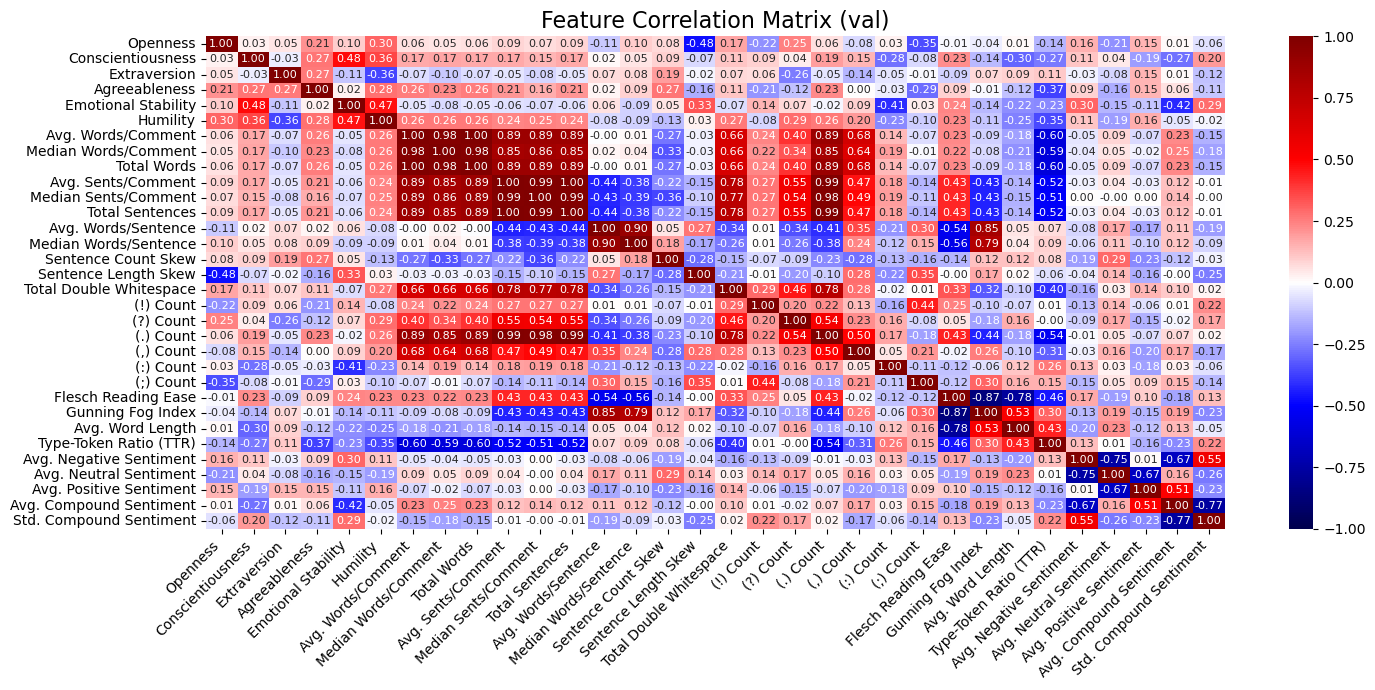

Converting VAL data to input structure...
Getting Q-scores for VAL...


Device set to use cuda


Q-Scoring user 1/32
Q-Scoring user 2/32
Q-Scoring user 3/32
Q-Scoring user 4/32
Q-Scoring user 5/32
Q-Scoring user 6/32
Q-Scoring user 7/32
Q-Scoring user 8/32
Q-Scoring user 9/32
Q-Scoring user 10/32


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Q-Scoring user 11/32
Q-Scoring user 12/32
Q-Scoring user 13/32
Q-Scoring user 14/32
Q-Scoring user 15/32
Q-Scoring user 16/32
Q-Scoring user 17/32
Q-Scoring user 18/32
Q-Scoring user 19/32
Q-Scoring user 20/32
Q-Scoring user 21/32
Q-Scoring user 22/32
Q-Scoring user 23/32
Q-Scoring user 24/32
Q-Scoring user 25/32
Q-Scoring user 26/32
Q-Scoring user 27/32
Q-Scoring user 28/32
Q-Scoring user 29/32
Q-Scoring user 30/32
Q-Scoring user 31/32
Q-Scoring user 32/32
Tokenizing comments and preparing data for Hugging Face Dataset...


Saving the dataset (1/1 shards): 100%|██████████| 32/32 [00:00<00:00, 2047.88 examples/s]

Finished processing. Hugging Face Dataset saved to val_hf_dataset


In [7]:
val_dataset_path = df_preprocess(r'..\shared task\data\val_data_realvalued.csv')

In [8]:
test_dataset_path = df_preprocess(r'..\shared task\data\test_data_a.csv')


Processing TEST data from CSV...
Extracting features for TEST...
Converting TEST data to input structure...
Getting Q-scores for TEST...


Device set to use cuda


Q-Scoring user 1/1000
Q-Scoring user 2/1000
Q-Scoring user 3/1000
Q-Scoring user 4/1000
Q-Scoring user 5/1000
Q-Scoring user 6/1000
Q-Scoring user 7/1000
Q-Scoring user 8/1000
Q-Scoring user 9/1000
Q-Scoring user 10/1000
Q-Scoring user 11/1000
Q-Scoring user 12/1000
Q-Scoring user 13/1000
Q-Scoring user 14/1000
Q-Scoring user 15/1000
Q-Scoring user 16/1000
Q-Scoring user 17/1000
Q-Scoring user 18/1000
Q-Scoring user 19/1000
Q-Scoring user 20/1000
Q-Scoring user 21/1000
Q-Scoring user 22/1000
Q-Scoring user 23/1000
Q-Scoring user 24/1000
Q-Scoring user 25/1000
Q-Scoring user 26/1000
Q-Scoring user 27/1000
Q-Scoring user 28/1000
Q-Scoring user 29/1000
Q-Scoring user 30/1000
Q-Scoring user 31/1000
Q-Scoring user 32/1000
Q-Scoring user 33/1000
Q-Scoring user 34/1000
Q-Scoring user 35/1000
Q-Scoring user 36/1000
Q-Scoring user 37/1000
Q-Scoring user 38/1000
Q-Scoring user 39/1000
Q-Scoring user 40/1000
Q-Scoring user 41/1000
Q-Scoring user 42/1000
Q-Scoring user 43/1000
Q-Scoring user 44/10

Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 63995.12 examples/s]

Finished processing. Hugging Face Dataset saved to test_hf_dataset


In [ ]:
# TO PYARROW
import json
import pyarrow as pa
import pyarrow.feather as feather # For writing Feather files (a common Arrow on-disk format)
import argparse
from tqdm import tqdm # For progress bar

def extract_data_from_json_line(line_str):
    """
    Parses a single JSON line and extracts data into a flat dictionary.
    """
    try:
        record = json.loads(line_str)
    except json.JSONDecodeError:
        print(f"Warning: Skipping malformed JSON line: {line_str[:100]}...")
        return None

    features_data = record.get("features")
    if not features_data:
        print(f"Warning: Skipping line, 'features' key not found: {line_str[:100]}...")
        return None

    flat_data = {}

    # Scalar features
    scalar_feature_keys = [
        "mean_words_per_comment", "median_words_per_comment", "mean_sents_per_comment",
        "median_sents_per_comment", "mean_words_per_sentence", "median_words_per_sentence",
        "sents_per_comment_skew", "words_per_sentence_skew", "total_double_whitespace",
        "punc_em_total", "punc_qm_total", "punc_period_total", "punc_comma_total",
        "punc_colon_total", "punc_semicolon_total", "flesch_reading_ease_agg",
        "gunning_fog_agg", "mean_word_len_overall", "ttr_overall", "mean_sentiment_neg",
        "mean_sentiment_neu", "mean_sentiment_pos", "mean_sentiment_compound",
        "std_sentiment_compound"
    ]
    for key in scalar_feature_keys:
        flat_data[key] = features_data.get(key)

    # q_scores (list of lists of floats)
    flat_data["q_scores"] = features_data.get("q_scores")

    # Tokenized data
    comments_tokenized = features_data.get("comments_tokenized", {}).get("data", {})
    if comments_tokenized: # Ensure it exists
        flat_data["input_ids"] = comments_tokenized.get("input_ids", {}).get("data")
        flat_data["token_type_ids"] = comments_tokenized.get("token_type_ids", {}).get("data")
        flat_data["attention_mask"] = comments_tokenized.get("attention_mask", {}).get("data")
    else: # If comments_tokenized or its 'data' sub-key is missing
        flat_data["input_ids"] = None
        flat_data["token_type_ids"] = None
        flat_data["attention_mask"] = None
        
    return flat_data

def define_arrow_schema():
    """
    Defines the PyArrow schema based on the expected data structure.
    This provides more robustness than inferring the schema.
    """
    fields = [
        # Scalar float features
        pa.field("mean_words_per_comment", pa.float64()),
        pa.field("median_words_per_comment", pa.float64()),
        pa.field("mean_sents_per_comment", pa.float64()),
        pa.field("median_sents_per_comment", pa.float64()),
        pa.field("mean_words_per_sentence", pa.float64()),
        pa.field("median_words_per_sentence", pa.float64()),
        pa.field("sents_per_comment_skew", pa.float64()),
        pa.field("words_per_sentence_skew", pa.float64()),
        pa.field("total_double_whitespace", pa.float64()), # Assuming float, could be int
        pa.field("punc_em_total", pa.float64()),
        pa.field("punc_qm_total", pa.float64()),
        pa.field("punc_period_total", pa.float64()),
        pa.field("punc_comma_total", pa.float64()),
        pa.field("punc_colon_total", pa.float64()),
        pa.field("punc_semicolon_total", pa.float64()),
        pa.field("flesch_reading_ease_agg", pa.float64()),
        pa.field("gunning_fog_agg", pa.float64()),
        pa.field("mean_word_len_overall", pa.float64()),
        pa.field("ttr_overall", pa.float64()),
        pa.field("mean_sentiment_neg", pa.float64()),
        pa.field("mean_sentiment_neu", pa.float64()),
        pa.field("mean_sentiment_pos", pa.float64()),
        pa.field("mean_sentiment_compound", pa.float64()),
        pa.field("std_sentiment_compound", pa.float64()),

        # List features
        pa.field("q_scores", pa.list_(pa.list_(pa.float64()))), # List of lists of floats

        # Tokenizer outputs (list of lists of ints)
        # The dtype was "torch.int64" in your example
        pa.field("input_ids", pa.list_(pa.list_(pa.int64()))),
        pa.field("token_type_ids", pa.list_(pa.list_(pa.int64()))),
        pa.field("attention_mask", pa.list_(pa.list_(pa.int64())))
    ]
    return pa.schema(fields)


def jsonl_to_arrow(jsonl_filepath, arrow_filepath):
    """
    Converts a JSONL file to an Arrow (Feather) file.
    """
    schema = define_arrow_schema()
    column_names = [field.name for field in schema]
    
    # Initialize lists to hold column data
    data_columns = {name: [] for name in column_names}

    print(f"Reading JSONL file: {jsonl_filepath}")
    with open(jsonl_filepath, 'r', encoding='utf-8') as f_jsonl:
        # Count lines for tqdm progress bar if file is large
        # For very large files, consider not doing this or using a more efficient way
        num_lines = sum(1 for _ in open(jsonl_filepath, 'r', encoding='utf-8'))
        f_jsonl.seek(0) # Reset file pointer

        for line in tqdm(f_jsonl, total=num_lines, desc="Processing lines"):
            flat_data_row = extract_data_from_json_line(line)
            if flat_data_row:
                for col_name in column_names:
                    data_columns[col_name].append(flat_data_row.get(col_name))
            # If flat_data_row is None, it means the line was skipped, so we don't append

    if not any(data_columns.values()): # Check if any data was actually processed
        print("No valid data processed. Arrow file will not be created.")
        return

    print("Creating PyArrow Table...")
    try:
        # Create PyArrow arrays for each column
        arrays = []
        for name in column_names:
            try:
                # Attempt to create array with specified type from schema
                # PyArrow can often infer, but explicit casting helps with Nones
                # For list types, ensure Nones are handled if items can be missing
                if data_columns[name] and isinstance(schema.field(name).type, (pa.ListType, pa.LargeListType)):
                     # For list types, we might need to be careful if individual rows have None for the whole list
                     # e.g., pa.array(data_columns[name], type=schema.field(name).type, safe=False) # if complex
                     arrays.append(pa.array(data_columns[name], type=schema.field(name).type))
                else:
                    arrays.append(pa.array(data_columns[name], type=schema.field(name).type))
            except pa.ArrowInvalid as e:
                print(f"Error creating array for column '{name}': {e}")
                print(f"First 5 problematic values: {data_columns[name][:5]}")
                # Fallback or raise error
                # For simplicity, let's try inferring type if explicit fails for some reason
                print(f"Attempting to infer type for column '{name}'...")
                arrays.append(pa.array(data_columns[name]))


        arrow_table = pa.Table.from_arrays(arrays, schema=schema)
    except Exception as e:
        print(f"Error creating PyArrow table: {e}")
        print("Trying to create table by inferring schema from pydict (might be less robust)...")
        # Fallback: let from_pydict infer (might not match desired complex types perfectly)
        arrow_table = pa.Table.from_pydict(data_columns)


    print(f"Writing Arrow (Feather) file: {arrow_filepath}")
    feather.write_feather(arrow_table, arrow_filepath)
    print("Conversion complete.")
    print(f"Arrow table schema:\n{arrow_table.schema}")

def main():
    parser = argparse.ArgumentParser(description="Convert JSONL file to Arrow (Feather) format.")
    parser.add_argument("jsonl_file", help="Path to the input JSONL file.")
    parser.add_argument("arrow_file", help="Path to the output Arrow (Feather) file.")
    args = parser.parse_args()

    jsonl_to_arrow(args.jsonl_file, args.arrow_file)

    # Example: Verify with Hugging Face datasets
    try:
        from datasets import load_from_disk, Features, Value, Sequence, ClassLabel, Dataset
        
        print(f"\nVerifying with Hugging Face datasets by loading '{args.arrow_file}'...")
        
        # For a single .arrow (Feather) file, you can load it like this:
        # Note: HF datasets `features` argument helps in being explicit
        # Construct HF Features object based on PyArrow schema
        hf_features_dict = {}
        pyarrow_schema = define_arrow_schema() # or loaded_table.schema
        for field in pyarrow_schema:
            if pa.types.is_float64(field.type) or pa.types.is_float32(field.type):
                hf_features_dict[field.name] = Value("float64") # or float32
            elif pa.types.is_int64(field.type) or pa.types.is_int32(field.type): # Add other int types if needed
                hf_features_dict[field.name] = Value("int64") # or int32
            elif pa.types.is_list(field.type) or pa.types.is_large_list(field.type):
                # This gets nested. For [[float]], it's Sequence(Sequence(Value("float64")))
                # For [[int]], it's Sequence(Sequence(Value("int64")))
                inner_value_type = field.type.value_type # This is pa.list_(<inner_type>)
                if pa.types.is_list(inner_value_type) or pa.types.is_large_list(inner_value_type):
                    innermost_value_type = inner_value_type.value_type
                    if pa.types.is_float64(innermost_value_type) or pa.types.is_float32(innermost_value_type):
                        hf_features_dict[field.name] = Sequence(Sequence(Value("float64")))
                    elif pa.types.is_int64(innermost_value_type) or pa.types.is_int32(innermost_value_type):
                         hf_features_dict[field.name] = Sequence(Sequence(Value("int64")))
                    else:
                        print(f"Warning: Unhandled innermost list type for HF Features: {innermost_value_type} for field {field.name}")
                        hf_features_dict[field.name] = Sequence(Sequence(Value("string"))) # Fallback
                else: # Simple list like list<int>
                    # This case is not in your example data for top-level features
                    print(f"Warning: Unhandled simple list type for HF Features: {inner_value_type} for field {field.name}")
                    hf_features_dict[field.name] = Sequence(Value("string")) # Fallback
            else:
                print(f"Warning: Unhandled PyArrow type for HF Features: {field.type} for field {field.name}")
                hf_features_dict[field.name] = Value("string") # Fallback

        hf_features = Features(hf_features_dict)
        
        # Load the Arrow file directly
        # dataset = Dataset.from_file(args.arrow_file, features=hf_features) # if it's Arrow IPC stream
        dataset = Dataset.from_pandas(feather.read_table(args.arrow_file).to_pandas(), features=hf_features)


        print("Successfully loaded into Hugging Face Dataset object.")
        print(dataset)
        if len(dataset) > 0:
            print("First record:", dataset[0])
        else:
            print("Dataset is empty.")

    except ImportError:
        print("\n`datasets` library not installed. Skipping Hugging Face verification.")
    except Exception as e:
        print(f"\nError during Hugging Face datasets verification: {e}")

In [ ]:
# clean corr pics
df_v = pd.read_csv('df_val_feat.csv')
df_t = pd.read_csv('df_train_feat.csv')


In [ ]:
# TRAIN
show_corr(df_t)

In [ ]:
# VAL
show_corr(df_v,cols_drop='id')


In [ ]:
# topic modeling
    # per author
    # per comment

# REAL TRAINING



In [1]:
import json
import torch
from torch.utils.data import IterableDataset
from transformers.tokenization_utils_base import BatchEncoding # For your decode_from_json
import logging
import random
import numpy as np
import torch.nn.functional as F
from transformers import BertModel, BertConfig, get_linear_schedule_with_warmup
from typing import Optional, Tuple, Dict, Union
from torch import nn
import optuna
from torch.utils.data import DataLoader
import gc
from transformers.tokenization_utils_base import BatchEncoding # For type checking and instantiation
import torch.optim as optim
import os
import shutil # Keep for now, might be useful for other file ops if needed later

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Constants for JSON (ensure these match what you used when saving) ---
_TENSOR_MARKER = "__tensor__"
_TENSOR_DTYPE_MARKER = "__tensor_dtype__"
_BATCH_ENCODING_MARKER = "__batch_encoding__"
_BATCH_ENCODING_DATA_MARKER = "data"

def _convert_str_to_dtype(dtype_str: str) -> torch.dtype:
    if not dtype_str.startswith("torch."):
        try:
            return torch.__getattribute__(dtype_str)
        except AttributeError:
            return torch.dtype(dtype_str)
    dtype_name = dtype_str.split('.')[1]
    return torch.__getattribute__(dtype_name)

def _json_object_hook_for_dataset(dct: dict) -> any:
    if _TENSOR_MARKER in dct:
        dtype_str = dct.get(_TENSOR_DTYPE_MARKER, 'float32')
        dtype = _convert_str_to_dtype(dtype_str)
        return torch.tensor(dct[_BATCH_ENCODING_DATA_MARKER], dtype=dtype)
    elif _BATCH_ENCODING_MARKER in dct:
        reconstructed_data_for_be = {}
        batch_encoding_payload = dct.get(_BATCH_ENCODING_DATA_MARKER, {})
        for k, v_data in batch_encoding_payload.items():
            if isinstance(v_data, list) and k in ["input_ids", "token_type_ids", "attention_mask"]:
                try:
                    tensor_dtype = torch.long if k in ["input_ids", "token_type_ids"] else torch.long
                    reconstructed_data_for_be[k] = torch.tensor(v_data, dtype=tensor_dtype)
                except Exception as e:
                    logger.error(f"Error converting field '{k}' in BatchEncoding to tensor: {e}. Keeping as list.")
                    reconstructed_data_for_be[k] = v_data
            else:
                reconstructed_data_for_be[k] = v_data
        return BatchEncoding(reconstructed_data_for_be)
    return dct

class JsonlIterableDataset(IterableDataset):
    def __init__(self, file_path, trait_names, n_comments_to_process,
                 other_numerical_feature_names, num_q_features_per_comment,
                 is_test_set=False, transform_fn=None, num_samples = None):
        super().__init__()
        self.file_path = file_path
        self.trait_names_ordered = trait_names
        self.n_comments_to_process = n_comments_to_process
        self.other_numerical_feature_names = other_numerical_feature_names
        self.num_q_features_per_comment = num_q_features_per_comment
        self.is_test_set = is_test_set
        self.transform_fn = self._default_transform if transform_fn is None else transform_fn
        if num_samples is None:
            logger.info(f'Counting samples in {file_path} for __len__ was not provided...')
            self.num_samples = self._count_samples_in_file()
            logger.info(f"Counted {self.num_samples} samples in {self.file_path}.")
        else:
            self.num_samples = num_samples
        if self.num_samples == 0:
            logger.warning(f"Initialized JsonlIterableDataset for {self.file_path} with 0 samples. DataLoader will be empty.")

    def _count_samples_in_file(self):
            count = 0
            try:
                with open(self.file_path, 'r', encoding='utf-8') as f:
                    for _ in f:
                        count += 1
            except FileNotFoundError:
                logger.error(f"File not found during initial sample count: {self.file_path}. Returning 0 samples.")
                return 0
            except Exception as e:
                logger.error(f"Error during initial sample count for {self.file_path}: {e}. Returning 0 samples.")
                return 0
            return count

    def _process_line(self, line):
        try:
            sample = json.loads(line, object_hook=_json_object_hook_for_dataset)
            return self.transform_fn(sample, idx=None)
        except json.JSONDecodeError:
            return None
        except Exception:
            return None

    def __len__(self):
        return self.num_samples

    def _default_transform(self, sample, idx):
        tokenized_info = sample.get('features', {}).get('comments_tokenized', {})
        all_input_ids = tokenized_info['input_ids']
        all_attention_mask = tokenized_info['attention_mask']

        num_actual_comments = all_input_ids.shape[0]
        final_input_ids = torch.zeros((self.n_comments_to_process, all_input_ids.shape[1]), dtype=torch.long)
        final_attention_mask = torch.zeros((self.n_comments_to_process, all_attention_mask.shape[1]), dtype=torch.long)
        comment_active_flags = torch.zeros(self.n_comments_to_process, dtype=torch.bool)

        indices_to_select = list(range(num_actual_comments))
        if num_actual_comments > self.n_comments_to_process:
            indices_to_select = random.sample(indices_to_select, self.n_comments_to_process)
            comments_to_fill = self.n_comments_to_process
        else:
            comments_to_fill = num_actual_comments

        for i in range(comments_to_fill):
            original_idx = indices_to_select[i]
            final_input_ids[i] = all_input_ids[original_idx]
            final_attention_mask[i] = all_attention_mask[original_idx]
            comment_active_flags[i] = True

        raw_q_scores = sample['features'].get('q_scores', [])
        final_q_scores = torch.zeros((self.n_comments_to_process, self.num_q_features_per_comment), dtype=torch.float)

        selected_raw_q_scores = []
        for i in range(comments_to_fill):
            original_comment_idx = indices_to_select[i]
            if original_comment_idx < len(raw_q_scores):
                qs_for_comment = raw_q_scores[original_comment_idx][:self.num_q_features_per_comment]
                padded_qs = qs_for_comment + [0.0] * (self.num_q_features_per_comment - len(qs_for_comment))
                selected_raw_q_scores.append(padded_qs[:self.num_q_features_per_comment])
            else:
                selected_raw_q_scores.append([0.0] * self.num_q_features_per_comment)

        if comments_to_fill > 0 and selected_raw_q_scores:
            try:
                final_q_scores[:comments_to_fill] = torch.tensor(selected_raw_q_scores, dtype=torch.float)
            except Exception as e:
                logger.error(f"Error converting selected_raw_q_scores to tensor: {e}. Data: {selected_raw_q_scores}")

        other_numerical_features_list = []
        for fname in self.other_numerical_feature_names:
            val = sample['features'].get(fname, 0.0)
            try:
                other_numerical_features_list.append(float(val))
            except (ValueError, TypeError):
                other_numerical_features_list.append(0.0)
        other_numerical_features_tensor = torch.tensor(other_numerical_features_list, dtype=torch.float)

        if not self.is_test_set:
            labels_dict = sample['labels']
            regression_labels = []
            for trait_key in self.trait_names_ordered:
                label_val = labels_dict.get(trait_key.title(), labels_dict.get(trait_key, 0.0))
                try:
                    label_float = float(label_val)
                    if not (0.0 <= label_float <= 1.0): label_float = np.clip(label_float, 0.0, 1.0)
                    regression_labels.append(label_float)
                except (ValueError, TypeError): regression_labels.append(0.0)
            labels_tensor = torch.tensor(regression_labels, dtype=torch.float)
            return (final_input_ids, final_attention_mask, final_q_scores, comment_active_flags, other_numerical_features_tensor, labels_tensor)
        else:
            return (final_input_ids, final_attention_mask, final_q_scores, comment_active_flags, other_numerical_features_tensor)

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        try:
            file_iter = open(self.file_path, 'r', encoding='utf-8')
        except FileNotFoundError:
            logger.error(f"File not found in __iter__: {self.file_path}. Yielding nothing.")
            return

        if worker_info is None:
            for line in file_iter:
                processed_item = self._process_line(line)
                if processed_item:
                    yield processed_item
        else:
            num_workers = worker_info.num_workers
            worker_id = worker_info.id
            for i, line in enumerate(file_iter):
                if i % num_workers == worker_id:
                    processed_item = self._process_line(line)
                    if processed_item:
                        yield processed_item
        file_iter.close()


class PersonalityModelV3(nn.Module):
    def __init__(self,
                 bert_model_name: str,
                 num_traits: int,
                 n_comments_to_process: int = 3,
                 dropout_rate: float = 0.2,
                 attention_hidden_dim: int = 128,
                 num_bert_layers_to_pool: int = 4,
                 num_q_features_per_comment: int = 3,
                 num_other_numerical_features: int = 0,
                 numerical_embedding_dim: int = 64,
                 num_additional_dense_layers: int = 0,
                 additional_dense_hidden_dim: int = 256,
                 additional_layers_dropout_rate: float = 0.3
                ):
        super().__init__()
        self.bert_config = BertConfig.from_pretrained(bert_model_name, output_hidden_states=True)
        self.bert = BertModel.from_pretrained(bert_model_name, config=self.bert_config)
        self.n_comments_to_process = n_comments_to_process
        self.num_bert_layers_to_pool = num_bert_layers_to_pool
        bert_hidden_size = self.bert.config.hidden_size
        self.num_q_features_per_comment = num_q_features_per_comment

        comment_feature_dim = bert_hidden_size + self.num_q_features_per_comment
        self.attention_w = nn.Linear(comment_feature_dim, attention_hidden_dim)
        self.attention_v = nn.Linear(attention_hidden_dim, 1, bias=False)
        
        self.final_dropout_layer = nn.Dropout(dropout_rate) 

        self.num_other_numerical_features = num_other_numerical_features
        self.uses_other_numerical_features = self.num_other_numerical_features > 0
        self.other_numerical_processor_output_dim = 0
        
        aggregated_comment_feature_dim = comment_feature_dim 
        combined_input_dim_for_block = aggregated_comment_feature_dim

        if self.uses_other_numerical_features:
            self.other_numerical_processor_output_dim = numerical_embedding_dim
            self.other_numerical_processor = nn.Sequential(
                nn.Linear(self.num_other_numerical_features, self.other_numerical_processor_output_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            combined_input_dim_for_block += self.other_numerical_processor_output_dim
            logger.info(f"Model will use {self.num_other_numerical_features} other numerical features, processed to dim {self.other_numerical_processor_output_dim}.")
        else:
            logger.info("Model will NOT use other numerical features.")

        self.num_additional_dense_layers = num_additional_dense_layers
        self.additional_dense_block = nn.Sequential()
        current_dim_for_dense_block = combined_input_dim_for_block

        if self.num_additional_dense_layers > 0:
            logger.info(f"Model using {self.num_additional_dense_layers} additional dense layers with hidden_dim {additional_dense_hidden_dim} and dropout {additional_layers_dropout_rate}")
            for i in range(self.num_additional_dense_layers):
                self.additional_dense_block.add_module(f"add_dense_{i}_linear", nn.Linear(current_dim_for_dense_block, additional_dense_hidden_dim))
                self.additional_dense_block.add_module(f"add_dense_{i}_relu", nn.ReLU())
                self.additional_dense_block.add_module(f"add_dense_{i}_dropout", nn.Dropout(additional_layers_dropout_rate))
                current_dim_for_dense_block = additional_dense_hidden_dim
            input_dim_for_regressors = current_dim_for_dense_block
        else:
            logger.info("Model not using additional dense layers. Will use final_dropout_layer if dropout_rate > 0.")
            input_dim_for_regressors = combined_input_dim_for_block

        self.trait_regressors = nn.ModuleList()
        for _ in range(num_traits):
            self.trait_regressors.append(
                nn.Linear(input_dim_for_regressors, 1)
            )

    def _pool_bert_layers(self, all_hidden_states: Tuple[torch.Tensor, ...], attention_mask: torch.Tensor) -> torch.Tensor:
        layers_to_pool = all_hidden_states[-self.num_bert_layers_to_pool:]
        pooled_outputs = []
        expanded_attention_mask = attention_mask.unsqueeze(-1).expand_as(layers_to_pool[0])
        
        for layer_hidden_states in layers_to_pool:
            sum_embeddings = torch.sum(layer_hidden_states * expanded_attention_mask, dim=1)
            sum_mask = expanded_attention_mask.sum(dim=1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            pooled_outputs.append(sum_embeddings / sum_mask)
            
        stacked_pooled_outputs = torch.stack(pooled_outputs, dim=0)
        mean_pooled_layers_embedding = torch.mean(stacked_pooled_outputs, dim=0)
        return mean_pooled_layers_embedding

    def forward(self,
                input_ids: torch.Tensor,
                attention_mask: torch.Tensor,
                q_scores: torch.Tensor,
                comment_active_mask: torch.Tensor,
                other_numerical_features: Optional[torch.Tensor] = None
               ):
        batch_size = input_ids.shape[0]
        
        input_ids_flat = input_ids.view(-1, input_ids.shape[-1])
        attention_mask_flat = attention_mask.view(-1, attention_mask.shape[-1])
        
        bert_outputs = self.bert(input_ids=input_ids_flat, attention_mask=attention_mask_flat)
        comment_bert_embeddings_flat = self._pool_bert_layers(bert_outputs.hidden_states, attention_mask_flat)
        comment_bert_embeddings = comment_bert_embeddings_flat.view(batch_size, self.n_comments_to_process, -1)
        
        comment_features_with_q = torch.cat((comment_bert_embeddings, q_scores), dim=2)
        
        u = torch.tanh(self.attention_w(comment_features_with_q))
        scores = self.attention_v(u).squeeze(-1)
        
        if comment_active_mask is not None:
            scores = scores.masked_fill(~comment_active_mask, -1e9)
            
        attention_weights = F.softmax(scores, dim=1)
        attention_weights_expanded = attention_weights.unsqueeze(-1)
        
        aggregated_comment_features = torch.sum(attention_weights_expanded * comment_features_with_q, dim=1)

        final_features_for_processing = aggregated_comment_features
        if self.uses_other_numerical_features:
            if other_numerical_features is None or other_numerical_features.shape[1] != self.num_other_numerical_features:
                raise ValueError(
                    f"Other numerical features expected but not provided correctly. "
                    f"Expected {self.num_other_numerical_features}, got shape {other_numerical_features.shape if other_numerical_features is not None else 'None'}"
                )
            processed_other_numerical_features = self.other_numerical_processor(other_numerical_features)
            final_features_for_processing = torch.cat((aggregated_comment_features, processed_other_numerical_features), dim=1)
        
        if self.num_additional_dense_layers > 0:
            features_for_trait_heads = self.additional_dense_block(final_features_for_processing)
        else:
            features_for_trait_heads = self.final_dropout_layer(final_features_for_processing)
        
        trait_regression_outputs = []
        for regressor_head in self.trait_regressors:
            trait_regression_outputs.append(regressor_head(features_for_trait_heads))
        
        all_trait_outputs_raw = torch.cat(trait_regression_outputs, dim=1)
        all_trait_outputs_sigmoid = torch.sigmoid(all_trait_outputs_raw)
        
        return all_trait_outputs_sigmoid

    def predict_scores(self, outputs: torch.Tensor) -> torch.Tensor:
        return outputs

# --- Optuna Objective Function (MODIFIED for overall best model saving) ---
def objective(trial: optuna.trial.Trial,
              train_file_path: str,
              val_file_path: str,
              global_config: Dict,
              device: torch.device,
              num_epochs_per_trial: int, # Removed default
              ### NEW: Pass the path for saving the overall best model weights ###
              overall_best_weights_filepath: str 
             ):
    logger.info(f"Starting Optuna Trial {trial.number}")

    num_traits = len(global_config['TRAIT_NAMES'])
    other_numerical_feature_names_trial = global_config.get('OTHER_NUMERICAL_FEATURE_NAMES', [])
    num_other_numerical_features_trial = len(other_numerical_feature_names_trial)
    num_q_features_per_comment_trial = global_config.get('NUM_Q_FEATURES_PER_COMMENT', 3)

    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    attention_hidden_dim = trial.suggest_categorical("attention_hidden_dim", [128, 256, 512])
    lr_bert = trial.suggest_float("lr_bert", 5e-6, 1e-4, log=True)
    lr_head = trial.suggest_float("lr_head", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    num_bert_layers_to_pool = trial.suggest_int("num_bert_layers_to_pool", 1, 4)
    n_comments_trial = trial.suggest_int("n_comments_to_process", 3, global_config.get('MAX_COMMENTS_TO_PROCESS_PHYSICAL', 3))
    num_unfrozen_bert_layers = trial.suggest_int("num_unfrozen_bert_layers", 0, 6)
    patience_early_stopping = trial.suggest_int("patience_early_stopping", 3, 5)
    scheduler_type = trial.suggest_categorical("scheduler_type", ["none", "linear_warmup"])
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.2) if scheduler_type != "none" else 0.0
    batch_size_trial = trial.suggest_categorical("batch_size", [8, 16, 32])

    other_numerical_embedding_dim_trial = 0
    if num_other_numerical_features_trial > 0:
        other_numerical_embedding_dim_trial = trial.suggest_categorical("other_numerical_embedding_dim", [32, 64, 128])

    num_additional_dense_layers_trial = trial.suggest_int("num_additional_dense_layers", 0, 3)
    additional_dense_hidden_dim_trial = 0
    additional_layers_dropout_rate_trial = 0.0
    if num_additional_dense_layers_trial > 0:
        additional_dense_hidden_dim_trial = trial.suggest_categorical("additional_dense_hidden_dim", [128, 256, 512])
        additional_layers_dropout_rate_trial = trial.suggest_float("additional_layers_dropout_rate", 0.1, 0.5)

    logger.info(f"Trial {trial.number} - Suggested Parameters: {trial.params}")
    try:
        train_dataset_trial = JsonlIterableDataset(
            file_path=train_file_path,
            trait_names=global_config['TRAIT_NAMES_ORDERED'],
            n_comments_to_process=n_comments_trial,
            other_numerical_feature_names=other_numerical_feature_names_trial,
            num_q_features_per_comment=num_q_features_per_comment_trial,
            is_test_set=False, num_samples=global_config.get('NUM_TRAIN_SAMPLES')
        )
        val_dataset_trial = JsonlIterableDataset(
            file_path=val_file_path,
            trait_names=global_config['TRAIT_NAMES_ORDERED'],
            n_comments_to_process=n_comments_trial,
            other_numerical_feature_names=other_numerical_feature_names_trial,
            num_q_features_per_comment=num_q_features_per_comment_trial,
            is_test_set=False, num_samples=global_config.get('NUM_VAL_SAMPLES')
        )
        train_loader_trial = DataLoader(train_dataset_trial, batch_size=batch_size_trial, num_workers=0, pin_memory=True if device.type == 'cuda' else False, persistent_workers=False)
        val_loader_trial = DataLoader(val_dataset_trial, batch_size=batch_size_trial, num_workers=0, pin_memory=True if device.type == 'cuda' else False, persistent_workers=False)
    except Exception as e:
        logger.error(f"Trial {trial.number} - Error creating dataset/dataloader: {e}", exc_info=True)
        return float('inf')

    model = PersonalityModelV3(
        bert_model_name=global_config['BERT_MODEL_NAME'],
        num_traits=num_traits,
        n_comments_to_process=n_comments_trial,
        dropout_rate=dropout_rate,
        attention_hidden_dim=attention_hidden_dim,
        num_bert_layers_to_pool=num_bert_layers_to_pool,
        num_q_features_per_comment=num_q_features_per_comment_trial,
        num_other_numerical_features=num_other_numerical_features_trial,
        numerical_embedding_dim=other_numerical_embedding_dim_trial,
        num_additional_dense_layers=num_additional_dense_layers_trial,
        additional_dense_hidden_dim=additional_dense_hidden_dim_trial,
        additional_layers_dropout_rate=additional_layers_dropout_rate_trial
    ).to(device)

    for name, param in model.bert.named_parameters(): param.requires_grad = False
    if num_unfrozen_bert_layers > 0:
        if hasattr(model.bert, 'embeddings'):
            for param in model.bert.embeddings.parameters(): param.requires_grad = True
        actual_layers_to_unfreeze = min(num_unfrozen_bert_layers, model.bert.config.num_hidden_layers)
        for i in range(model.bert.config.num_hidden_layers - actual_layers_to_unfreeze, model.bert.config.num_hidden_layers):
            if i >= 0 and i < model.bert.config.num_hidden_layers :
                for param in model.bert.encoder.layer[i].parameters(): param.requires_grad = True
        if hasattr(model.bert, 'pooler') and model.bert.pooler is not None:
            for param in model.bert.pooler.parameters(): param.requires_grad = True
    
    logger.debug(f"Trial {trial.number} - BERT params requiring grad: "
                 f"{sum(p.numel() for p in model.bert.parameters() if p.requires_grad)}")

    optimizer_grouped_parameters = []
    bert_params_to_tune = [p for p in model.bert.parameters() if p.requires_grad]
    if bert_params_to_tune and lr_bert > 0:
         optimizer_grouped_parameters.append({"params": bert_params_to_tune, "lr": lr_bert, "weight_decay": 0.01})

    head_params = []
    head_params.extend(list(model.attention_w.parameters()))
    head_params.extend(list(model.attention_v.parameters()))
    if model.uses_other_numerical_features:
        head_params.extend(list(model.other_numerical_processor.parameters()))
    if model.num_additional_dense_layers > 0:
        head_params.extend(list(model.additional_dense_block.parameters()))
    for regressor_head in model.trait_regressors:
        head_params.extend(list(regressor_head.parameters()))
    
    if head_params:
        optimizer_grouped_parameters.append({"params": head_params, "lr": lr_head, "weight_decay": weight_decay})
        
    if not any(pg['params'] for pg in optimizer_grouped_parameters if pg.get('params')):
        logger.warning(f"Trial {trial.number} - No parameters to optimize. Skipping training.")
        return float('inf')

    optimizer = optim.AdamW(optimizer_grouped_parameters)
    
    scheduler = None
    if scheduler_type == "linear_warmup":
        if global_config.get('NUM_TRAIN_SAMPLES', 0) > 0:
            num_batches_per_epoch = (global_config['NUM_TRAIN_SAMPLES'] + batch_size_trial - 1) // batch_size_trial
            num_training_steps = num_batches_per_epoch * num_epochs_per_trial
            num_warmup_steps = int(num_training_steps * warmup_ratio)
            if num_warmup_steps > 0 and num_training_steps > 0:
                scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
            else:
                logger.warning(f"Trial {trial.number}: Calculated num_warmup_steps or num_training_steps is zero. Scheduler not created. Warmup: {num_warmup_steps}, Training: {num_training_steps}")
        else:
            logger.warning(f"Trial {trial.number}: NUM_TRAIN_SAMPLES not available or zero in global_config. Cannot create linear_warmup scheduler.")

    loss_fn = nn.L1Loss().to(device)
    best_val_loss_this_trial = float('inf') # For early stopping within this trial
    patience_counter = 0
                
    for epoch in range(num_epochs_per_trial):
        model.train()
        total_train_loss = 0
        train_batches_processed = 0
        for batch_idx, batch_tuple in enumerate(train_loader_trial):
            input_ids, attention_m, q_s, comment_active_m, other_num_feats, labels_reg = [b.to(device) for b in batch_tuple]
            optimizer.zero_grad()
            predicted_scores = model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
            current_batch_loss = loss_fn(predicted_scores, labels_reg)
            if torch.isnan(current_batch_loss) or torch.isinf(current_batch_loss):
                logger.warning(f"Trial {trial.number}, Epoch {epoch+1}, Batch {batch_idx}: NaN or Inf loss detected. Skipping batch.")
                torch.cuda.empty_cache()
                continue
            current_batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler: scheduler.step()
            total_train_loss += current_batch_loss.item()
            train_batches_processed += 1
            
        avg_train_loss = total_train_loss / train_batches_processed if train_batches_processed > 0 else float('inf')
        logger.info(f"Trial {trial.number}, Epoch {epoch+1}/{num_epochs_per_trial} completed. Avg Train Loss: {avg_train_loss:.4f}")

        model.eval()
        current_epoch_val_loss = 0
        val_batches_processed = 0
        all_val_preds_epoch = []
        all_val_labels_epoch = []
        with torch.no_grad():
            for batch_tuple in val_loader_trial:
                input_ids, attention_m, q_s, comment_active_m, other_num_feats, labels_reg = [b.to(device) for b in batch_tuple]
                if input_ids.numel() == 0: continue
                predicted_scores = model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
                if predicted_scores.numel() == 0: continue
                batch_val_loss = loss_fn(predicted_scores, labels_reg)
                current_epoch_val_loss += batch_val_loss.item()
                all_val_preds_epoch.append(predicted_scores.cpu())
                all_val_labels_epoch.append(labels_reg.cpu())
                val_batches_processed += 1

        avg_val_loss_epoch = current_epoch_val_loss / val_batches_processed if val_batches_processed > 0 else float('inf')
        
        val_mae = -1.0
        if all_val_labels_epoch and all_val_preds_epoch:
            all_val_labels_cat = torch.cat(all_val_labels_epoch, dim=0)
            all_val_preds_cat = torch.cat(all_val_preds_epoch, dim=0)
            if all_val_labels_cat.numel() > 0 and all_val_preds_cat.numel() > 0:
                val_mae = F.l1_loss(all_val_preds_cat, all_val_labels_cat).item()

        logger.info(f"Trial {trial.number}, Epoch {epoch+1} Val Loss (MSE): {avg_val_loss_epoch:.4f}, Val MAE: {val_mae:.4f}")

        # Check for improvement for early stopping within this trial
        if avg_val_loss_epoch < best_val_loss_this_trial:
            best_val_loss_this_trial = avg_val_loss_epoch
            patience_counter = 0
            logger.debug(f"Trial {trial.number}, Epoch {epoch+1}: New best val_loss for this trial: {best_val_loss_this_trial:.4f}")
        else:
            patience_counter += 1
        
        ### MODIFIED: Check against overall best and save if better ###
        # Ensure study user_attrs are available (should be, unless running trial standalone)
        if hasattr(trial, 'study') and trial.study is not None:
            current_overall_best_loss = trial.study.user_attrs.get("overall_best_val_loss", float('inf'))
            if avg_val_loss_epoch < current_overall_best_loss:
                logger.info(f"Trial {trial.number}, Epoch {epoch+1}: New OVERALL best val_loss: {avg_val_loss_epoch:.4f} (Previous overall best: {current_overall_best_loss:.4f}). Saving model.")
                trial.study.set_user_attr("overall_best_val_loss", avg_val_loss_epoch)
                trial.study.set_user_attr("overall_best_trial_number", trial.number)
                trial.study.set_user_attr("overall_best_epoch", epoch + 1)
                # Save model state dict (on CPU to be safe)
                model_state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}
                torch.save(model_state_dict_cpu, overall_best_weights_filepath)
                logger.info(f"Trial {trial.number}: Saved new OVERALL best model weights to {overall_best_weights_filepath}")
        else:
            logger.warning(f"Trial {trial.number}: Cannot access study.user_attrs to check/update overall best model.")


        trial.report(avg_val_loss_epoch, epoch)
        if trial.should_prune():
            logger.info(f"Trial {trial.number} pruned by Optuna at epoch {epoch+1}.")
            del model, train_loader_trial, val_loader_trial, optimizer, scheduler
            torch.cuda.empty_cache(); gc.collect()
            return best_val_loss_this_trial # Return this trial's best loss for Optuna's pruning logic
        
        if patience_counter >= patience_early_stopping:
            logger.info(f"Trial {trial.number} - Early stopping at epoch {epoch+1} (Patience: {patience_early_stopping}).")
            break
        
    logger.info(f"Trial {trial.number} finished. Best Val Loss (MSE) for this trial: {best_val_loss_this_trial:.4f}")
    del model, train_loader_trial, val_loader_trial, optimizer, scheduler
    torch.cuda.empty_cache(); gc.collect()
    return best_val_loss_this_trial # Return the best validation loss achieved in *this specific trial*

c:\Users\User\.local\share\mamba\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Assuming PersonalityDatasetV3, PersonalityModelV3, objective are defined/imported

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {DEVICE}")

TRAIN_DATA_FILE = "train_data.jsonl" 
VAL_DATA_FILE = "val_data.jsonl"
TEST_DATA_FILE = "test_data.jsonl"

_trait_names_ordered_config = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional stability', 'Humility']
_other_numerical_features_config = [
    'mean_words_per_comment', 'mean_sents_per_comment',
    'median_words_per_comment', 'mean_words_per_sentence', 'median_words_per_sentence',
    'sents_per_comment_skew', 'words_per_sentence_skew', 'total_double_whitespace',
    'punc_em_total', 'punc_qm_total', 'punc_period_total', 'punc_comma_total',
    'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
    'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
    'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
    'mean_sentiment_compound', 'std_sentiment_compound'
]

GLOBAL_CONFIG = {
    'BERT_MODEL_NAME': "bert-base-uncased",
    'TRAIT_NAMES_ORDERED': _trait_names_ordered_config,
    'TRAIT_NAMES': _trait_names_ordered_config,
    'MAX_COMMENTS_TO_PROCESS_PHYSICAL': 6,
    'NUM_Q_FEATURES_PER_COMMENT': 3,
    'OTHER_NUMERICAL_FEATURE_NAMES': _other_numerical_features_config,
    'TOKENIZER_MAX_LENGTH': 256
}

NUM_EPOCHS_PER_TRIAL_OPTUNA = 15
N_OPTUNA_TRIALS = 20

def count_lines_in_file(filepath):
    try:
        count = 0
        with open(filepath, 'r', encoding='utf-8') as f:
            for _ in f:
                count += 1
        return count
    except FileNotFoundError:
        logger.error(f"File not found for line counting: {filepath}. Returning 0.")
        return 0
    except Exception as e:
        logger.error(f"Error counting lines in {filepath}: {e}. Returning 0.")
        return 0

NUM_TRAIN_SAMPLES = count_lines_in_file(TRAIN_DATA_FILE)
if NUM_TRAIN_SAMPLES == 0:
    logger.error(f"Training file {TRAIN_DATA_FILE} is empty or not found. Exiting.")
    exit()
GLOBAL_CONFIG['NUM_TRAIN_SAMPLES'] = NUM_TRAIN_SAMPLES
logger.info(f"Number of training samples: {NUM_TRAIN_SAMPLES}")

NUM_VAL_SAMPLES = count_lines_in_file(VAL_DATA_FILE)
if NUM_VAL_SAMPLES == 0:
    logger.warning(f"Validation file {VAL_DATA_FILE} is empty or not found. Validation might not work as expected.")
GLOBAL_CONFIG['NUM_VAL_SAMPLES'] = NUM_VAL_SAMPLES
logger.info(f"Number of validation samples: {NUM_VAL_SAMPLES}")

logger.info(f"Starting Optuna study: {N_OPTUNA_TRIALS} trials, up to {NUM_EPOCHS_PER_TRIAL_OPTUNA} epochs/trial.")

study_name = "personality_regression_v9_overall_best"
storage_name = f"sqlite:///{study_name}.db"
BEST_PARAMS_FILENAME = f"{study_name}_best_params.json"
BEST_WEIGHTS_FILENAME = f"{study_name}_best_weights.pth" # This is the single file for the overall best model

study = optuna.create_study(study_name=study_name,
                            direction="minimize",
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=3, n_min_trials=5, interval_steps=1),
                            storage=storage_name,
                            load_if_exists=True)

# Initialize overall_best_val_loss in study.user_attrs if it doesn't exist
if "overall_best_val_loss" not in study.user_attrs:
    study.set_user_attr("overall_best_val_loss", float('inf'))
    logger.info(f"Initialized 'overall_best_val_loss' in study user_attrs to infinity.")
else:
    logger.info(f"Resuming study. Current 'overall_best_val_loss' in study user_attrs: {study.user_attrs['overall_best_val_loss']:.4f}")


if study.trials: logger.info(f"Resuming existing study {study.study_name} with {len(study.trials)} previous trials.")

try:
    study.optimize(
        lambda trial: objective(
            trial, TRAIN_DATA_FILE, VAL_DATA_FILE,
            GLOBAL_CONFIG, DEVICE, 
            num_epochs_per_trial=NUM_EPOCHS_PER_TRIAL_OPTUNA,
            overall_best_weights_filepath=BEST_WEIGHTS_FILENAME # Pass the path here
        ),
        n_trials=N_OPTUNA_TRIALS,
        gc_after_trial=True,
        timeout=10800
    )
except Exception as e:
    logger.exception("An error occurred during the Optuna study.")

logger.info("\n--- Optuna Study Finished ---")
logger.info(f"Number of finished trials: {len(study.trials)}")

best_trial_overall_from_study_obj = None 

if not study.trials:
    logger.warning("No trials were completed in the study.")
else:
    try:
        completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None]
        if completed_trials:
            best_trial_overall_from_study_obj = study.best_trial # Optuna's record of the best trial

            if best_trial_overall_from_study_obj:
                logger.info(f"Optuna's Best Trial (based on reported values):")
                logger.info(f"  Number: {best_trial_overall_from_study_obj.number}")
                logger.info(f"  Value (Validation Loss - MSE): {best_trial_overall_from_study_obj.value:.4f}") # This is the value *returned* by the objective for that trial
                logger.info("  Best Params (from this trial): ")
                for key, value in best_trial_overall_from_study_obj.params.items():
                    logger.info(f"    {key}: {value}")

                # Save the hyperparameters of Optuna's identified best trial
                with open(BEST_PARAMS_FILENAME, 'w') as f:
                    json.dump(best_trial_overall_from_study_obj.params, f, indent=4)
                logger.info(f"Best hyperparameters (from trial {best_trial_overall_from_study_obj.number}) saved to {BEST_PARAMS_FILENAME}")

                # The BEST_WEIGHTS_FILENAME should already contain the weights of the overall best model saved during the study.
                # We can log information about which trial/epoch produced it, if stored.
                overall_best_val_loss_attr = study.user_attrs.get("overall_best_val_loss", float('inf'))
                overall_best_trial_attr = study.user_attrs.get("overall_best_trial_number", "N/A")
                overall_best_epoch_attr = study.user_attrs.get("overall_best_epoch", "N/A")

                logger.info(f"Overall best model weights are expected in: {BEST_WEIGHTS_FILENAME}")
                if os.path.exists(BEST_WEIGHTS_FILENAME):
                    logger.info(f"  This model achieved a validation loss of: {overall_best_val_loss_attr:.4f} (recorded in study.user_attrs)")
                    logger.info(f"  It was saved from Trial: {overall_best_trial_attr}, Epoch: {overall_best_epoch_attr}")
                else:
                    logger.warning(f"  Expected overall best weights file {BEST_WEIGHTS_FILENAME} was NOT found. "
                                   "This might happen if no trial improved upon the initial 'inf' loss, "
                                   "or if there was an issue during saving.")
            else: # best_trial_overall_from_study_obj is None
                logger.warning("Study has completed trials, but study.best_trial is None. Cannot save parameters.")
        else: # No completed trials
            logger.warning("No trials completed successfully to determine the best trial. Cannot save parameters or confirm weights.")

        study_df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state', 'user_attrs'))
        study_df.to_csv(f"{study_name}_results.csv", index=False)
        logger.info(f"Optuna study results saved to {study_name}_results.csv")

    except Exception as e:
        logger.error(f"Could not process or save Optuna study results: {e}", exc_info=True)


# --- Example: Predicting on Test Data using saved best model and params ---
# This part remains largely the same, as it expects BEST_PARAMS_FILENAME and BEST_WEIGHTS_FILENAME
if os.path.exists(TEST_DATA_FILE) and os.path.exists(BEST_PARAMS_FILENAME) and os.path.exists(BEST_WEIGHTS_FILENAME):
    logger.info(f"\n--- Predicting on Test Data using overall best saved model and params ---")
    try:
        with open(BEST_PARAMS_FILENAME, 'r') as f:
            loaded_best_params = json.load(f)
        logger.info(f"Loaded best hyperparameters from {BEST_PARAMS_FILENAME}")

        test_model = PersonalityModelV3(
            bert_model_name=GLOBAL_CONFIG['BERT_MODEL_NAME'],
            num_traits=len(GLOBAL_CONFIG['TRAIT_NAMES']),
            n_comments_to_process=loaded_best_params.get("n_comments_to_process", GLOBAL_CONFIG['MAX_COMMENTS_TO_PROCESS_PHYSICAL']),
            dropout_rate=loaded_best_params.get("dropout_rate", 0.2),
            attention_hidden_dim=loaded_best_params.get("attention_hidden_dim", 128),
            num_bert_layers_to_pool=loaded_best_params.get("num_bert_layers_to_pool", 2),
            num_q_features_per_comment=GLOBAL_CONFIG['NUM_Q_FEATURES_PER_COMMENT'],
            num_other_numerical_features=len(GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES']),
            numerical_embedding_dim=loaded_best_params.get("other_numerical_embedding_dim", 0) if GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES'] else 0,
            num_additional_dense_layers=loaded_best_params.get("num_additional_dense_layers", 0),
            additional_dense_hidden_dim=loaded_best_params.get("additional_dense_hidden_dim", 256),
            additional_layers_dropout_rate=loaded_best_params.get("additional_layers_dropout_rate", 0.3)
        ).to(DEVICE)
        logger.info("Test model initialized with loaded best hyperparameters.")

        if torch.cuda.is_available():
            loaded_state_dict = torch.load(BEST_WEIGHTS_FILENAME)
        else:
            loaded_state_dict = torch.load(BEST_WEIGHTS_FILENAME, map_location=torch.device('cpu'))
        
        test_model.load_state_dict(loaded_state_dict)
        logger.info(f"Successfully loaded model weights from {BEST_WEIGHTS_FILENAME}")
        test_model.eval()

        NUM_TEST_SAMPLES = count_lines_in_file(TEST_DATA_FILE)
        if NUM_TEST_SAMPLES == 0:
             logger.warning(f"Test file {TEST_DATA_FILE} is empty or not found. No test predictions will be made.")
        else:
            test_dataset = JsonlIterableDataset(
                file_path=TEST_DATA_FILE,
                trait_names=GLOBAL_CONFIG['TRAIT_NAMES_ORDERED'],
                n_comments_to_process=loaded_best_params.get("n_comments_to_process", GLOBAL_CONFIG['MAX_COMMENTS_TO_PROCESS_PHYSICAL']),
                other_numerical_feature_names=GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES'],
                num_q_features_per_comment=GLOBAL_CONFIG['NUM_Q_FEATURES_PER_COMMENT'],
                is_test_set=True,
                num_samples=NUM_TEST_SAMPLES
            )
            test_batch_size = loaded_best_params.get("batch_size", 16)
            test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

            all_test_predictions = []
            with torch.no_grad():
                for batch_tuple in test_loader:
                    input_ids, attention_m, q_s, comment_active_m, other_num_feats = [b.to(DEVICE) for b in batch_tuple]
                    predicted_scores = test_model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
                    all_test_predictions.append(predicted_scores.cpu().numpy())

            if all_test_predictions:
                final_test_predictions = np.concatenate(all_test_predictions, axis=0)
                logger.info(f"Shape of final test predictions: {final_test_predictions.shape}")
                for i in range(min(5, len(final_test_predictions))):
                    pred_dict = {trait: round(score.item(), 4) for trait, score in zip(GLOBAL_CONFIG['TRAIT_NAMES_ORDERED'], final_test_predictions[i])}
                    logger.info(f"Test Sample Index {i} Predictions: {pred_dict}")
            else:
                logger.warning("No predictions generated for the test set (all_test_predictions list is empty).")
    
    except FileNotFoundError as e:
        logger.warning(f"Required file for test prediction not found: {e}. Skipping test prediction.")
    except Exception as e:
        logger.error(f"An error occurred during test prediction: {e}", exc_info=True)
elif not os.path.exists(TEST_DATA_FILE):
    logger.info(f"Test data file '{TEST_DATA_FILE}' not found. Skipping test prediction example.")
elif not os.path.exists(BEST_PARAMS_FILENAME) or not os.path.exists(BEST_WEIGHTS_FILENAME):
    logger.warning(f"Best parameters file ({BEST_PARAMS_FILENAME}) or weights file ({BEST_WEIGHTS_FILENAME}) not found. Skipping test prediction.")

2025-06-02 16:10:50,409 - INFO - Using device: cuda
2025-06-02 16:11:00,558 - INFO - Number of training samples: 1496
2025-06-02 16:11:00,558 - INFO - Number of validation samples: 32
2025-06-02 16:11:00,558 - INFO - Starting Optuna study: 20 trials, up to 15 epochs/trial.
[I 2025-06-02 16:11:01,350] A new study created in RDB with name: personality_regression_v9_overall_best
2025-06-02 16:11:01,358 - INFO - Initialized 'overall_best_val_loss' in study user_attrs to infinity.
2025-06-02 16:11:01,384 - INFO - Starting Optuna Trial 0
2025-06-02 16:11:01,468 - INFO - Trial 0 - Suggested Parameters: {'dropout_rate': 0.3780973770549795, 'attention_hidden_dim': 256, 'lr_bert': 6.126995933421536e-06, 'lr_head': 0.005756523975732954, 'weight_decay': 0.000485764227678845, 'num_bert_layers_to_pool': 1, 'n_comments_to_process': 6, 'num_unfrozen_bert_layers': 3, 'patience_early_stopping': 4, 'scheduler_type': 'none', 'batch_size': 16, 'other_numerical_embedding_dim': 64, 'num_additional_dense_laye

In [ ]:
# Suggested Parameters: {'dropout_rate': 0.3139769315197808, 'attention_hidden_dim': 512, 'lr_bert': 4.482712286372e-05, 'lr_head': 0.0009071103113561308, 'weight_decay': 2.108803440565371e-05, 'num_bert_layers_to_pool': 2, 'n_comments_to_process': 3, 'num_unfrozen_bert_layers': 0, 'patience_early_stopping': 5, 'scheduler_type': 'none', 'batch_size': 8, 'other_numerical_embedding_dim': 64}


# test

In [7]:
TEST_DATA_FILE = "val_data.jsonl"
# --- Example: Predicting on Test Data using saved best model and params ---
# This part remains largely the same, as it expects BEST_PARAMS_FILENAME and BEST_WEIGHTS_FILENAME
if os.path.exists(TEST_DATA_FILE) and os.path.exists(BEST_PARAMS_FILENAME) and os.path.exists(BEST_WEIGHTS_FILENAME):
    logger.info(f"\n--- Predicting on Test Data using overall best saved model and params ---")
    try:
        with open(BEST_PARAMS_FILENAME, 'r') as f:
            loaded_best_params = json.load(f)
        logger.info(f"Loaded best hyperparameters from {BEST_PARAMS_FILENAME}")

        test_model = PersonalityModelV3(
            bert_model_name=GLOBAL_CONFIG['BERT_MODEL_NAME'],
            num_traits=len(GLOBAL_CONFIG['TRAIT_NAMES']),
            n_comments_to_process=loaded_best_params.get("n_comments_to_process", GLOBAL_CONFIG['MAX_COMMENTS_TO_PROCESS_PHYSICAL']),
            dropout_rate=loaded_best_params.get("dropout_rate", 0.2),
            attention_hidden_dim=loaded_best_params.get("attention_hidden_dim", 128),
            num_bert_layers_to_pool=loaded_best_params.get("num_bert_layers_to_pool", 2),
            num_q_features_per_comment=GLOBAL_CONFIG['NUM_Q_FEATURES_PER_COMMENT'],
            num_other_numerical_features=len(GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES']),
            numerical_embedding_dim=loaded_best_params.get("other_numerical_embedding_dim", 0) if GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES'] else 0,
            num_additional_dense_layers=loaded_best_params.get("num_additional_dense_layers", 0),
            additional_dense_hidden_dim=loaded_best_params.get("additional_dense_hidden_dim", 256),
            additional_layers_dropout_rate=loaded_best_params.get("additional_layers_dropout_rate", 0.3)
        ).to(DEVICE)
        logger.info("Test model initialized with loaded best hyperparameters.")

        if torch.cuda.is_available():
            loaded_state_dict = torch.load(BEST_WEIGHTS_FILENAME)
        else:
            loaded_state_dict = torch.load(BEST_WEIGHTS_FILENAME, map_location=torch.device('cpu'))
        
        test_model.load_state_dict(loaded_state_dict)
        logger.info(f"Successfully loaded model weights from {BEST_WEIGHTS_FILENAME}")
        test_model.eval()

        NUM_TEST_SAMPLES = count_lines_in_file(TEST_DATA_FILE)
        if NUM_TEST_SAMPLES == 0:
             logger.warning(f"Test file {TEST_DATA_FILE} is empty or not found. No test predictions will be made.")
        else:
            test_dataset = JsonlIterableDataset(
                file_path=TEST_DATA_FILE,
                trait_names=GLOBAL_CONFIG['TRAIT_NAMES_ORDERED'],
                n_comments_to_process=loaded_best_params.get("n_comments_to_process", GLOBAL_CONFIG['MAX_COMMENTS_TO_PROCESS_PHYSICAL']),
                other_numerical_feature_names=GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES'],
                num_q_features_per_comment=GLOBAL_CONFIG['NUM_Q_FEATURES_PER_COMMENT'],
                is_test_set=True,
                num_samples=NUM_TEST_SAMPLES
            )
            test_batch_size = loaded_best_params.get("batch_size", 16)
            test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

            all_test_predictions = []
            with torch.no_grad():
                for batch_tuple in test_loader:
                    input_ids, attention_m, q_s, comment_active_m, other_num_feats = [b.to(DEVICE) for b in batch_tuple]
                    predicted_scores = test_model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
                    all_test_predictions.append(predicted_scores.cpu().numpy())

            if all_test_predictions:
                final_test_predictions = np.concatenate(all_test_predictions, axis=0)
                logger.info(f"Shape of final test predictions: {final_test_predictions.shape}")
                results = []
                for i in range(max(5, len(final_test_predictions))):
                    pred_dict = {trait: round(score.item(), 2) for trait, score in zip(GLOBAL_CONFIG['TRAIT_NAMES_ORDERED'], final_test_predictions[i])}
                    logger.info(f"Test Sample Index {i} Predictions: {pred_dict}")
                    results.append(pred_dict)
            else:
                logger.warning("No predictions generated for the test set (all_test_predictions list is empty).")

            
            
    
    except FileNotFoundError as e:
        logger.warning(f"Required file for test prediction not found: {e}. Skipping test prediction.")
    except Exception as e:
        logger.error(f"An error occurred during test prediction: {e}", exc_info=True)
elif not os.path.exists(TEST_DATA_FILE):
    logger.info(f"Test data file '{TEST_DATA_FILE}' not found. Skipping test prediction example.")
elif not os.path.exists(BEST_PARAMS_FILENAME) or not os.path.exists(BEST_WEIGHTS_FILENAME):
    logger.warning(f"Best parameters file ({BEST_PARAMS_FILENAME}) or weights file ({BEST_WEIGHTS_FILENAME}) not found. Skipping test prediction.")

2025-06-03 02:37:42,225 - INFO - 
--- Predicting on Test Data using overall best saved model and params ---
2025-06-03 02:37:42,227 - INFO - Loaded best hyperparameters from personality_regression_v9_overall_best_best_params.json
2025-06-03 02:37:42,693 - INFO - Model will use 23 other numerical features, processed to dim 64.
2025-06-03 02:37:42,693 - INFO - Model using 3 additional dense layers with hidden_dim 128 and dropout 0.3331625213348204
2025-06-03 02:37:42,949 - INFO - Test model initialized with loaded best hyperparameters.
2025-06-03 02:37:43,410 - INFO - Successfully loaded model weights from personality_regression_v9_overall_best_best_weights.pth
2025-06-03 02:37:44,756 - INFO - Shape of final test predictions: (32, 6)
2025-06-03 02:37:44,757 - INFO - Test Sample Index 0 Predictions: {'Openness': 0.63, 'Conscientiousness': 0.32, 'Extraversion': 0.3, 'Agreeableness': 0.39, 'Emotional stability': 0.55, 'Humility': 0.07}
2025-06-03 02:37:44,758 - INFO - Test Sample Index 1 Pr

In [16]:
import pandas as pd
df_val = pd.read_csv(r'..\shared task\data\val_data.csv')
y_true = df_val[GLOBAL_CONFIG['TRAIT_NAMES_ORDERED']].values
def float_to_label(val):
    if val < 0.33:
        return 'low'
    elif val < 0.66:
        return 'medium'
    else:
        return 'high'
y_pred = np.array([
    [float_to_label(i[trait]) for trait in GLOBAL_CONFIG['TRAIT_NAMES_ORDERED']]
    for i in results
])
y_pred

array([['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'medium', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medium', 'medium', 'low'],
       ['medium', 'low', 'low', 'medi

In [11]:
y_true

array([['high', 'low', 'high', 'high', 'low', 'low'],
       ['high', 'low', 'high', 'high', 'medium', 'high'],
       ['high', 'high', 'high', 'high', 'medium', 'high'],
       ['low', 'low', 'medium', 'high', 'medium', 'high'],
       ['medium', 'low', 'low', 'high', 'low', 'high'],
       ['medium', 'low', 'low', 'high', 'medium', 'high'],
       ['high', 'medium', 'low', 'high', 'high', 'high'],
       ['high', 'low', 'high', 'high', 'low', 'high'],
       ['high', 'low', 'low', 'high', 'low', 'high'],
       ['medium', 'high', 'high', 'high', 'medium', 'medium'],
       ['low', 'low', 'low', 'low', 'low', 'low'],
       ['high', 'high', 'low', 'high', 'medium', 'high'],
       ['high', 'low', 'high', 'medium', 'low', 'low'],
       ['low', 'high', 'low', 'high', 'medium', 'high'],
       ['medium', 'low', 'low', 'low', 'medium', 'medium'],
       ['high', 'medium', 'high', 'high', 'medium', 'medium'],
       ['high', 'low', 'low', 'low', 'high', 'high'],
       ['high', 'low', 'lo

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
for i, trait in enumerate(GLOBAL_CONFIG['TRAIT_NAMES_ORDERED']):
    print(f"\nTrait: {trait}")
    print(classification_report(y_true[:,i], y_pred[:,i],zero_division=0))


Trait: Openness
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        20
         low       0.00      0.00      0.00         8
      medium       0.12      1.00      0.22         4

    accuracy                           0.12        32
   macro avg       0.04      0.33      0.07        32
weighted avg       0.02      0.12      0.03        32


Trait: Conscientiousness
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.60      0.90      0.72        20
      medium       0.00      0.00      0.00         6

    accuracy                           0.56        32
   macro avg       0.20      0.30      0.24        32
weighted avg       0.38      0.56      0.45        32


Trait: Extraversion
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.58        13
      mediu